# **Project4: 금속 주조 불량 판정 모델**
### **<분석 목표>** 
- **공정 환경과 공정 변수를 관리, 불량에 대응하여 공정 최적화 진행**
- **불량 판별하는 모델 구축하여 생산성 향상 추진 및 비용 절감 기대**

In [1]:
# 필요한 패키지 불러오기 
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, confusion_matrix, auc, precision_score, recall_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from imblearn.metrics import geometric_mean_score
from scipy.stats import boxcox
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.samplers import TPESampler
from sklearn.utils import resample
from scipy.stats import chi2_contingency
import seaborn as sns
import itertools

### **데이터 불러오기 및 데이터 기본 정보 확인하기**

In [2]:
# 데이터 불러오기
df = pd.read_csv('./data_week4.csv', encoding='cp949')
df.head()
df.columns
df.info()
df.isnull().sum()
df.nunique()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92015 entries, 0 to 92014
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    92015 non-null  int64  
 1   line                          92015 non-null  object 
 2   name                          92015 non-null  object 
 3   mold_name                     92015 non-null  object 
 4   time                          92015 non-null  object 
 5   date                          92015 non-null  object 
 6   count                         92015 non-null  int64  
 7   working                       92014 non-null  object 
 8   emergency_stop                92014 non-null  object 
 9   molten_temp                   89754 non-null  float64
 10  facility_operation_cycleTime  92015 non-null  int64  
 11  production_cycletime          92015 non-null  int64  
 12  low_section_speed             92014 non-null  float64
 13  h

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\237379340.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data_week4.csv', encoding='cp949')


Unnamed: 0                      92015
line                                1
name                                1
mold_name                           1
time                               85
date                            54640
count                             334
working                             2
emergency_stop                      1
molten_temp                       113
facility_operation_cycleTime      195
production_cycletime              202
low_section_speed                 123
high_section_speed                230
molten_volume                     121
cast_pressure                     124
biscuit_thickness                  67
upper_mold_temp1                  317
upper_mold_temp2                  232
upper_mold_temp3                  117
lower_mold_temp1                  345
lower_mold_temp2                  323
lower_mold_temp3                  314
sleeve_temperature                590
physical_strength                 106
Coolant_temperature                35
EMS_operatio

### **데이터 전처리** 

In [3]:
# 컬럼명 변경
df.columns = ['Unnamed:0', '작업라인', '제품명', '금형명', '수집날짜', '수집시각', '일자별제품생산번호',
              '가동여부', '비상정지', '용탕온도', '설비작동사이클시간', '제품생산사이클시간',
              '저속구간속도', '고속구간속도', '용탕량', '주조압력', '비스킷두께', '상금형온도1',
              '상금형온도2', '상금형온도3', '하금형온도1', '하금형온도2', '하금형온도3', '슬리브온도',
              '형체력', '냉각수온도', '전자교반가동시간', '등록일시', '불량판정', '사탕신호', '금형코드',
              '가열로']

In [4]:
# 결측치 비율 확인
df['불량판정'].value_counts()
len(df[df['불량판정'] == 0]) /len(df) * 100
len(df[df['불량판정'] == 1]) / len(df) * 100

4.3645057870999295

결측치 값이 30% 이상인 데이터들은 데이터의 완전성이 떨어지기 때문에 삭제

In [5]:
# 데이터 완전성 만족 못하는 행 드롭 
df = df[df.isnull().mean(axis=1) * 100 <= 30]   

- 사탕 신호가 ‘D’로 측정될 때, 해당 생산품은 전부 불량 판정(=1)
- 해당 생산품은 다른 설명 변수를 고려하지 않고 사탕 신호로만 불량 여부 설명을 했다고 판단
- 따라서, ‘D’인 행들은 분석에서 고려하지 않기로 결정

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2037943737.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['사탕신호'] = df['사탕신호'].replace('D', 1)  # 'D'를 1로 변환


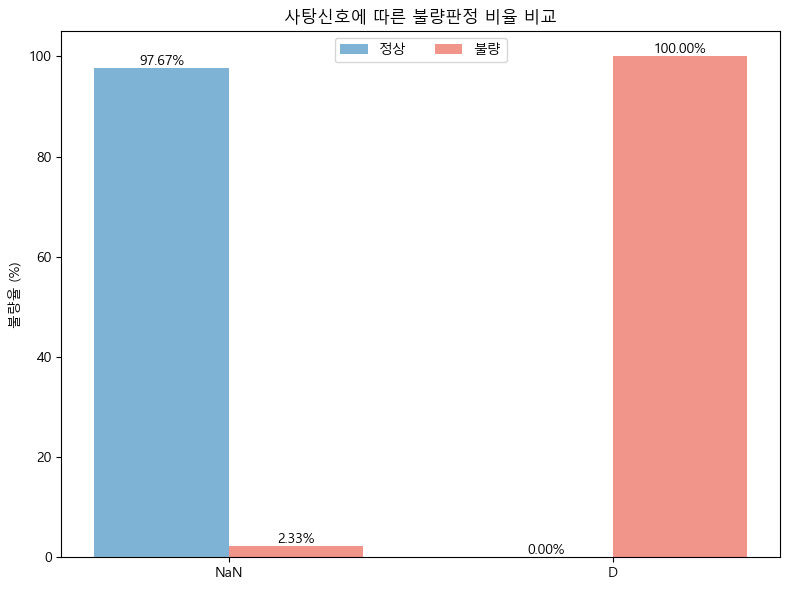

In [6]:
# NaN 값을 0으로 변환하고, 'D'는 1로 변환하는 코드 실행
df['사탕신호'] = df['사탕신호'].replace('D', 1)  # 'D'를 1로 변환
df['사탕신호'] = df['사탕신호'].fillna(0)  # NaN을 0으로 변환

# 사탕신호의 unique 값 확인
df['사탕신호'].unique()

plt.rcParams['font.family'] = 'Malgun Gothic'

# 사탕신호가 1일 때 불량판정이 0인 비율과 1인 비율을 계산
filtered_df = df[df['사탕신호'] == 1]
filtered_df_zero = df[df['사탕신호'] == 0]

# 불량판정의 비율 계산
#passorfail_0_ratio = (filtered_df['불량판정'].value_counts(normalize=True)[0] * 100).round(2)
#사탕신호 1인 것 중 실제 불량이 0인 비율 0%라 오류 뜸

passorfail_0_ratio = 0.0
#사탕신호 1인 것 중 실제 불량이 0인 비율은 0.0으로 수동 대체

passorfail_1_ratio = (filtered_df['불량판정'].value_counts(normalize=True)[1] * 100).round(2)
#사탕신호 1인 것 중 실제 불량이 1인 비율 100%

passorfail_0_ratio_zero = (filtered_df_zero['불량판정'].value_counts(normalize=True)[0] * 100).round(2)
#사탕신호 0인 것 중 실제 불량도 0인 비율 97.67%

passorfail_1_ratio_zero = (filtered_df_zero['불량판정'].value_counts(normalize=True)[1] * 100).round(2)
#사탕신호 0인 것 중 실제 불량이 1인 비율 2.33%

# 비율 데이터를 리스트로 저장
labels = ['NaN', 'D']
fail_0_ratios = [passorfail_0_ratio_zero, passorfail_0_ratio]  # 불량판정 0 비율
fail_1_ratios = [passorfail_1_ratio_zero, passorfail_1_ratio]  # 불량판정 1 비율

x = np.arange(len(labels))  # 라벨의 개수만큼 x 위치 생성
width = 0.35  # 막대 너비

fig, ax = plt.subplots(figsize=(8, 6))

# 불량판정 0 막대 그래프 그리기
bars1 = ax.bar(x - width/2, fail_0_ratios, width, label='정상', color='#7FB3D5')

# 불량판정 1 막대 그래프 그리기
bars2 = ax.bar(x + width/2, fail_1_ratios, width, label='불량', color='#F1948A')

# 각각의 막대에 % 비율 추가
for bar in bars1:
    ax.annotate(f'{bar.get_height():.2f}%', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom')

for bar in bars2:
    ax.annotate(f'{bar.get_height():.2f}%', 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom')

# 그래프 레이블 설정
ax.set_ylabel('불량율 (%)')
ax.set_title('사탕신호에 따른 불량판정 비율 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2)

# 그래프 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

In [7]:
# '사탕신호'가 'D'인 행 Drop
df = df[df['사탕신호'] != 1]

- 사용하지 않을 열 드롭. 
- '등록일시' datetime 형식으로 데이터 타입 변경
- 범주형 데이터 타입 변경


In [8]:
# 열 Drop (등록일시 포함)
eda_df = df.copy()
eda_df =  eda_df.drop(columns=['Unnamed:0', '일자별제품생산번호', '작업라인', '사탕신호', '제품명', '금형명', '비상정지', '수집날짜', '수집시각'])
df = df.drop(columns=['Unnamed:0', '일자별제품생산번호', '작업라인', '사탕신호', '제품명', '금형명', '비상정지', '수집날짜', '수집시각', '등록일시'])

# '불량판정', '금형코드' 열을 범주형으로 변환

df['불량판정'] = df['불량판정'].astype('category')
df['금형코드'] = df['금형코드'].astype('category')

eda_df['불량판정'] = eda_df['불량판정'].astype('category')
eda_df['금형코드'] = eda_df['금형코드'].astype('category')

df.isna().sum()

가동여부             0
용탕온도          2261
설비작동사이클시간        0
제품생산사이클시간        0
저속구간속도           0
고속구간속도           0
용탕량          44353
주조압력             0
비스킷두께            0
상금형온도1           0
상금형온도2           0
상금형온도3         312
하금형온도1           0
하금형온도2           0
하금형온도3         312
슬리브온도            0
형체력              0
냉각수온도            0
전자교반가동시간         0
불량판정             0
금형코드             0
가열로          48003
dtype: int64

### **기초통계량 보기**
1. 불량(1)인 데이터들의 온도(주조압력, 상금형온도1,2, 하금형온도 1,2)들의 평균과 중위값이 낮음.
2. 불량(1)인 데이터들의 주조압력 평균과 중위값이 낮음. 

In [9]:
numeric_df = df[['용탕온도', '설비작동사이클시간', '제품생산사이클시간',
              '저속구간속도', '고속구간속도', '용탕량', '주조압력', '비스킷두께', '상금형온도1',
              '상금형온도2', '상금형온도3', '하금형온도1', '하금형온도2', '하금형온도3', '슬리브온도',
              '형체력', '냉각수온도', '전자교반가동시간']]
category_df = df[['가동여부', '금형코드', '가열로']]

In [10]:
numeric_df.describe()

용탕온도     설비작동사이클시간     제품생산사이클시간        저속구간속도        고속구간속도  \
count  87834.000000  90095.000000  90095.000000  90095.000000  90095.000000   
mean     718.455200    121.587114    122.625129    110.322182    112.682768   
std       51.926599     12.030442     13.308901    218.154686     10.695703   
min        0.000000     69.000000      0.000000      0.000000      0.000000   
25%      712.000000    117.000000    119.000000    110.000000    112.000000   
50%      728.000000    119.000000    121.000000    110.000000    112.000000   
75%      730.000000    122.000000    123.000000    110.000000    112.000000   
max      735.000000    457.000000    485.000000  65534.000000    388.000000   

                용탕량          주조압력         비스킷두께        상금형온도1        상금형온도2  \
count  45742.000000  90095.000000  90095.000000  90095.000000  90095.000000   
mean     156.924074    326.521727     50.316244    187.351018    166.350486   
std      490.855165     20.655991     13.357600     45.156640     31.382495   
min        0.000000     41.000000      0.000000     19.000000     15.000000   
25%       49.000000    329.000000     47.000000    165.000000    148.000000   
50%       67.000000    330.000000     50.000000    194.000000    173.000000   
75%       85.000000    331.000000     53.000000    222.000000    185.000000   
max     2767.000000    348.000000    422.000000   1449.000000   4232.000000   

             상금형온도3        하금형온도1        하금형온도2        하금형온도3         슬리브온도  \
count  89783.000000  90095.000000  90095.000000  89783.000000  90095.000000   
mean    1317.275754    205.169710    201.165259   1442.318780    421.448027   
std      396.084589     52.542008     43.656187    220.919796    113.429744   
min       42.000000     20.000000     21.000000    299.000000     27.000000   
25%     1449.000000    167.000000    174.000000   1449.000000    386.000000   
50%     1449.000000    210.000000    199.000000   1449.000000    463.000000   
75%     1449.000000    251.000000    231.000000   1449.000000    485.000000   
max     1449.000000    369.000000    504.000000  65503.000000   1449.000000   

                형체력        냉각수온도      전자교반가동시간  
count  90095.000000  90095.00000  90095.000000  
mean     701.902714     32.41373     18.463222  
std      377.044232     14.39469      8.324629  
min        0.000000     17.00000      0.000000  
25%      697.000000     31.00000     23.000000  
50%      703.000000     32.00000     23.000000  
75%      710.000000     34.00000     23.000000  
max    65535.000000   1449.00000     25.000000

In [11]:
defect_df = numeric_df[df['불량판정']==1]
defect_df.describe()

용탕온도   설비작동사이클시간    제품생산사이클시간        저속구간속도       고속구간속도  \
count  2033.000000  2097.00000  2097.000000   2097.000000  2097.000000   
mean    712.895229   122.37196   117.927992    127.536481   124.660944   
std      68.144873    13.25430    21.057470   1429.435233    41.884690   
min       0.000000    70.00000     0.000000      0.000000     0.000000   
25%     711.000000   118.00000   118.000000    102.000000   112.000000   
50%     718.000000   120.00000   121.000000    110.000000   112.000000   
75%     730.000000   123.00000   123.000000    110.000000   113.000000   
max     735.000000   232.00000   363.000000  65534.000000   388.000000   

               용탕량         주조압력        비스킷두께       상금형온도1       상금형온도2  \
count  1022.000000  2097.000000  2097.000000  2097.000000  2097.000000   
mean    229.718200   223.746781    65.731044   140.749165   130.046257   
std     651.364399    80.235390    82.022387    64.834294    97.095718   
min       0.000000    41.000000     0.000000    19.000000    15.000000   
25%      44.000000   158.000000    45.000000    98.000000   109.000000   
50%      67.000000   173.000000    49.000000   137.000000   123.000000   
75%      90.000000   325.000000    53.000000   184.000000   154.000000   
max    2767.000000   338.000000   422.000000  1449.000000  4232.000000   

            상금형온도3       하금형온도1       하금형온도2       하금형온도3        슬리브온도  \
count  2097.000000  2097.000000  2097.000000  2097.000000  2097.000000   
mean   1205.827849   153.327611   151.462089  1444.195041   444.342871   
std     518.769421    59.699158    61.304098    46.037640    93.163897   
min      42.000000    20.000000    21.000000   642.000000    27.000000   
25%    1449.000000   110.000000   111.000000  1449.000000   423.000000   
50%    1449.000000   148.000000   142.000000  1449.000000   458.000000   
75%    1449.000000   189.000000   183.000000  1449.000000   482.000000   
max    1449.000000   367.000000   482.000000  1449.000000  1449.000000   

                형체력        냉각수온도     전자교반가동시간  
count   2097.000000  2097.000000  2097.000000  
mean     776.483071    33.010968    20.999523  
std     2454.292146    62.041304     5.983796  
min        0.000000    17.000000     0.000000  
25%      697.000000    27.000000    23.000000  
50%      704.000000    31.000000    23.000000  
75%      709.000000    33.000000    23.000000  
max    65535.000000  1449.000000    23.000000

In [12]:
nondefect_df = numeric_df[df['불량판정'] == 0]
nondefect_df.describe()

용탕온도     설비작동사이클시간     제품생산사이클시간        저속구간속도        고속구간속도  \
count  85801.000000  87998.000000  87998.000000  87998.000000  87998.000000   
mean     718.586940    121.568411    122.737062    109.911964    112.397327   
std       51.473626     11.999211     13.047904      7.025948      8.475689   
min        0.000000     69.000000      0.000000      1.000000     90.000000   
25%      713.000000    117.000000    119.000000    110.000000    112.000000   
50%      728.000000    119.000000    121.000000    110.000000    112.000000   
75%      730.000000    122.000000    123.000000    110.000000    112.000000   
max      735.000000    457.000000    485.000000    140.000000    345.000000   

                용탕량          주조압력         비스킷두께        상금형온도1        상금형온도2  \
count  44720.000000  87998.000000  87998.000000  87998.000000  87998.000000   
mean     155.260487    328.970863     49.948908    188.461545    167.215619   
std      486.450886      5.078062      4.078436     43.984155     27.415659   
min        0.000000    149.000000      1.000000     22.000000     32.000000   
25%       49.000000    329.000000     47.000000    167.000000    149.000000   
50%       67.000000    330.000000     50.000000    195.000000    173.000000   
75%       85.000000    331.000000     53.000000    223.000000    185.000000   
max     2767.000000    348.000000     60.000000    356.000000    333.000000   

             상금형온도3        하금형온도1        하금형온도2        하금형온도3         슬리브온도  \
count  87686.000000  87998.000000  87998.000000  87686.000000  87998.000000   
mean    1319.941017    206.405111    202.349690   1442.273909    420.902441   
std      392.297999     51.729941     42.443965    223.432314    113.812958   
min       64.000000     43.000000     26.000000    299.000000     40.000000   
25%     1449.000000    169.000000    176.000000   1449.000000    385.000000   
50%     1449.000000    211.000000    200.000000   1449.000000    463.000000   
75%     1449.000000    251.000000    234.000000   1449.000000    485.000000   
max     1449.000000    369.000000    504.000000  65503.000000   1449.000000   

                형체력         냉각수온도      전자교반가동시간  
count  87998.000000  87998.000000  87998.000000  
mean     700.125457     32.399498     18.402782  
std       44.040044     10.975152      8.363077  
min        0.000000     18.000000      0.000000  
25%      697.000000     31.000000     23.000000  
50%      703.000000     32.000000     23.000000  
75%      710.000000     34.000000     23.000000  
max      737.000000   1449.000000     25.000000

###  **시각화**

#### Target: 불량판정

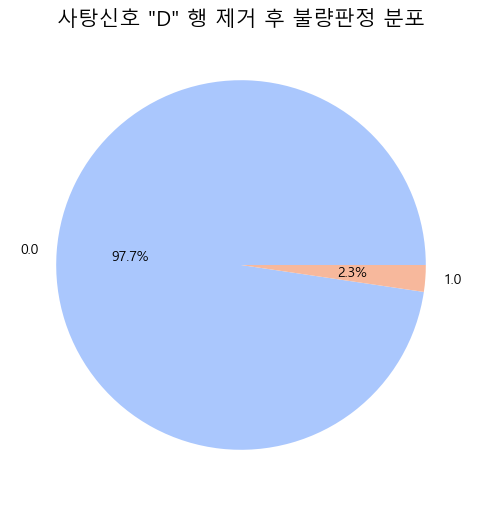

In [13]:
# 불량판정의 카운트 값 계산
counts = df['불량판정'].value_counts()

# '불량' 판정을 강조하기 위해 분리 (불량이 '1.0'이라고 가정)
explode = [0.1 if label == '1' else 0 for label in counts.index]  # '1.0' 부분을 강조

# 화려한 색상 팔레트 (색상 조정)
colors = sns.color_palette('coolwarm', len(counts))

# 파이 차트 그리기 (불량 조각을 빼냄)
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', explode=explode, colors=colors, wedgeprops={'edgecolor': 'none'})
plt.title('사탕신호 "D" 행 제거 후 불량판정 분포', fontsize=15)
plt.show()

### **수치형 변수 시각화**
#### 수치형 변수 박스플롯
- 주조압력, 상금형 온도1, 하금형온도1, 하금형온도2의 불량판정에 따른 분포가 상이한 것을 확인할 수 있음

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\230946264.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='불량판정', y=col, palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_5392\230946264.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='불량판정', y=col, palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_5392\230946264.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='불량판정', y=col, palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_5392\230946264.py:21: FutureWarning: 

Passin

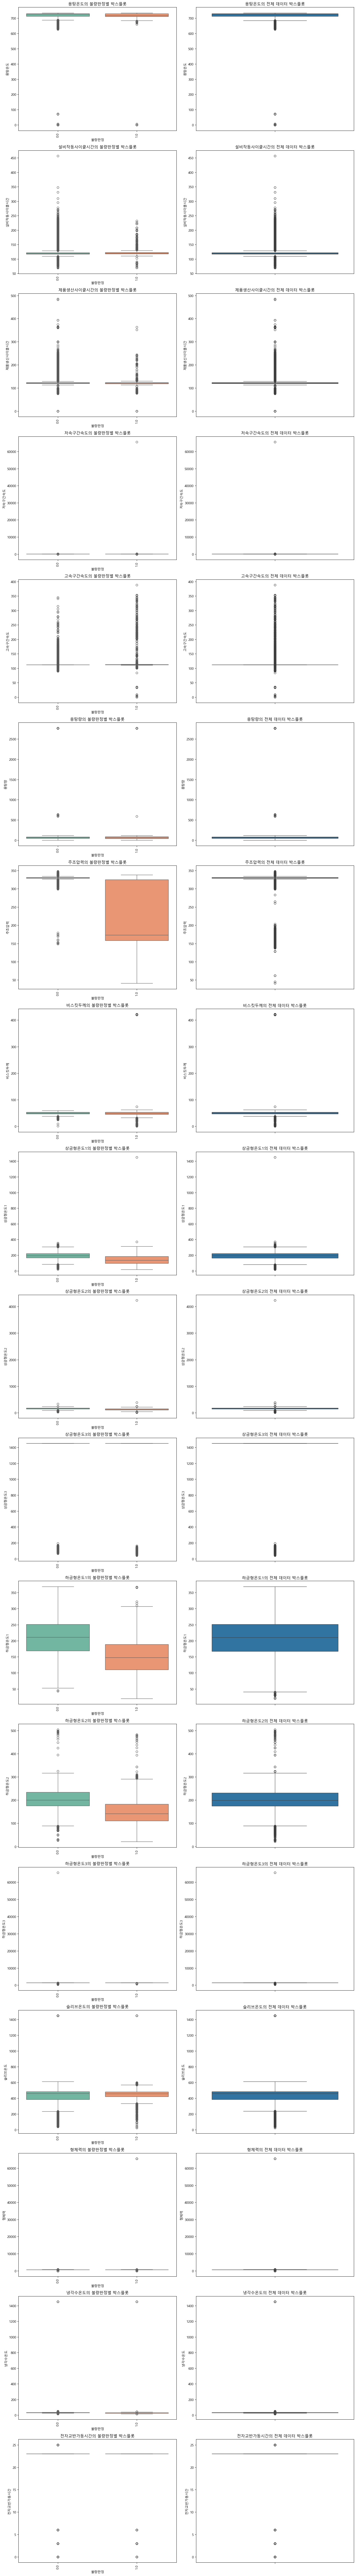

In [14]:
# 수치형 변수들에 대한 박스플롯을 서브플롯으로 그리는 함수
def boxplot_subplots(df):
    # 수치형 변수 선택 (int64와 float64 타입만 선택)
    numeric_cols = numeric_df.columns  
    
    # 불량판정을 범주형 변수로 변환 (안전성을 위해 처리)
    if '불량판정' in df.columns:
        df['불량판정'] = df['불량판정'].astype(str)
    
    # 서브플롯 행 계산 (한 열에 두 개의 서브플롯 배치)
    total_plots = len(numeric_cols) * 2  # 한 변수당 2개의 플롯
    max_cols = 2  # 한 행에 2개의 서브플롯
    max_rows = int(np.ceil(total_plots / max_cols))  # 행 개수 계산
    
    plt.figure(figsize=(15, 6 * max_rows))  # 전체 플롯 크기 설정
    
    plot_index = 1
    for col in numeric_cols:
        # 첫 번째 서브플롯: 불량판정 기준으로 박스플롯
        plt.subplot(max_rows, max_cols, plot_index)
        sns.boxplot(data=df, x='불량판정', y=col, palette='Set2')
        plt.title(f'{col}의 불량판정별 박스플롯', fontsize=12)
        plt.xlabel('불량판정', fontsize=10)
        plt.ylabel(col, fontsize=10)
        plt.xticks(rotation=90)
        plot_index += 1
        
        # 두 번째 서브플롯: 전체 데이터를 대상으로 박스플롯
        plt.subplot(max_rows, max_cols, plot_index)
        sns.boxplot(data=df, y=col)
        plt.title(f'{col}의 전체 데이터 박스플롯', fontsize=12)
        plt.ylabel(col, fontsize=10)
        plt.xticks(rotation=90)
        plot_index += 1
    
    plt.tight_layout()  # 서브플롯 간의 간격 조정
    plt.show()

# 박스플롯 그리기
boxplot_subplots(df)

#### 일별 변화율 변화
- 1월 2일, 1월 27일, 2월 12일의 불량판정평균이 높음

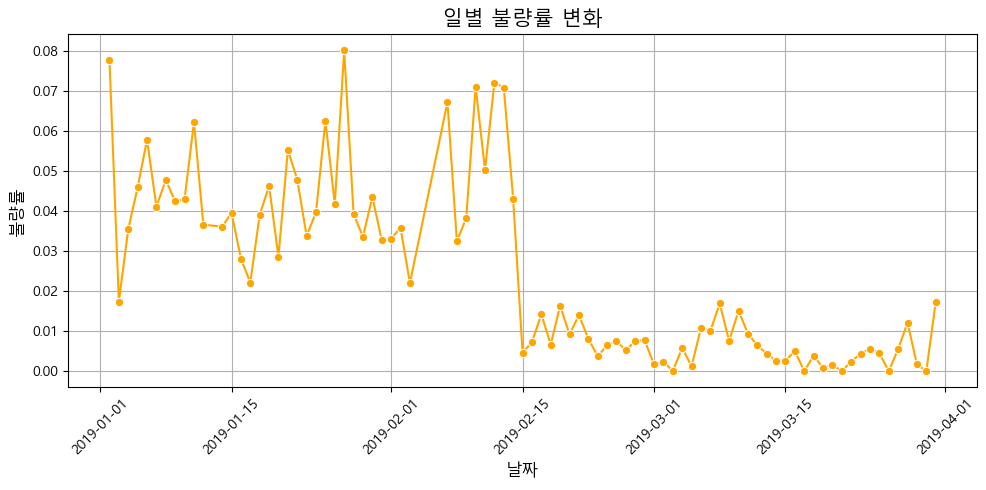

          Date  Failure Rate
24  2019-01-27      0.080257
0   2019-01-02      0.077778
37  2019-02-12      0.072212


In [15]:

# 불량판정 열을 float으로 변환
eda_df['불량판정'] = pd.to_numeric(eda_df['불량판정'], errors='coerce')
# 불량 판정의 일별 불량률 계산
def plot_daily_failure_rate(df, date_col, fail_col):
    # '등록일시' 열을 datetime 형식으로 변환
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    # '불량판정' 열을 숫자형(float)으로 변환
    df[fail_col] = pd.to_numeric(df[fail_col], errors='coerce')
    
    # 일별로 그룹화하여 불량률 계산
    daily_failure_rate = df.groupby(df[date_col].dt.date)[fail_col].mean().reset_index()
    daily_failure_rate.columns = ['Date', 'Failure Rate']  # 새로운 열 이름 설정
    
    # 그래프 그리기
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=daily_failure_rate, x='Date', y='Failure Rate', marker='o', color='orange')
    
    # 그래프 설정
    plt.title('일별 불량률 변화', fontsize=15)
    plt.xlabel('날짜', fontsize=12)
    plt.ylabel('불량률', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # 그래프 출력
    plt.tight_layout()
    plt.show()
    
    return daily_failure_rate  # 일별 불량률 데이터 반환

# 상위 n개의 불량률이 높은 날짜를 추출하는 함수
def find_top_n_failure_dates(df, n=3):
    # 불량률이 높은 순서대로 상위 n개 데이터 추출
    top_n = df.nlargest(n, 'Failure Rate')
    return top_n

# 일별 불량률 계산 및 그래프 그리기
daily_failure_rate = plot_daily_failure_rate(eda_df, '등록일시', '불량판정')

# 상위 3개의 날짜 추출
top_3_dates = find_top_n_failure_dates(daily_failure_rate, n=3)
print(top_3_dates)

#### 1월 27일 수치형 변수들과 불량률 라인그래프
- 설비작동사이클시간이 길 때 불량률 높은 경향을 보임
- 주조압력이 낮을 때 불량률 높은 경향을 보임
- 저속구간속도가 낮을 때 불량률 높은 경향을 보임
- 슬리브온도가 낮을 때 불량률 높은 경향을 보임
- 상금형온도1,2가 낮을 때 불량률이 높은 경향을 보임
- 하금형온도1,2가 낮을 때 불량률이 높은 경향을 보임

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2553915577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['불량률'] = daily_data[defect_col].rolling(window=10, min_periods=1).mean()


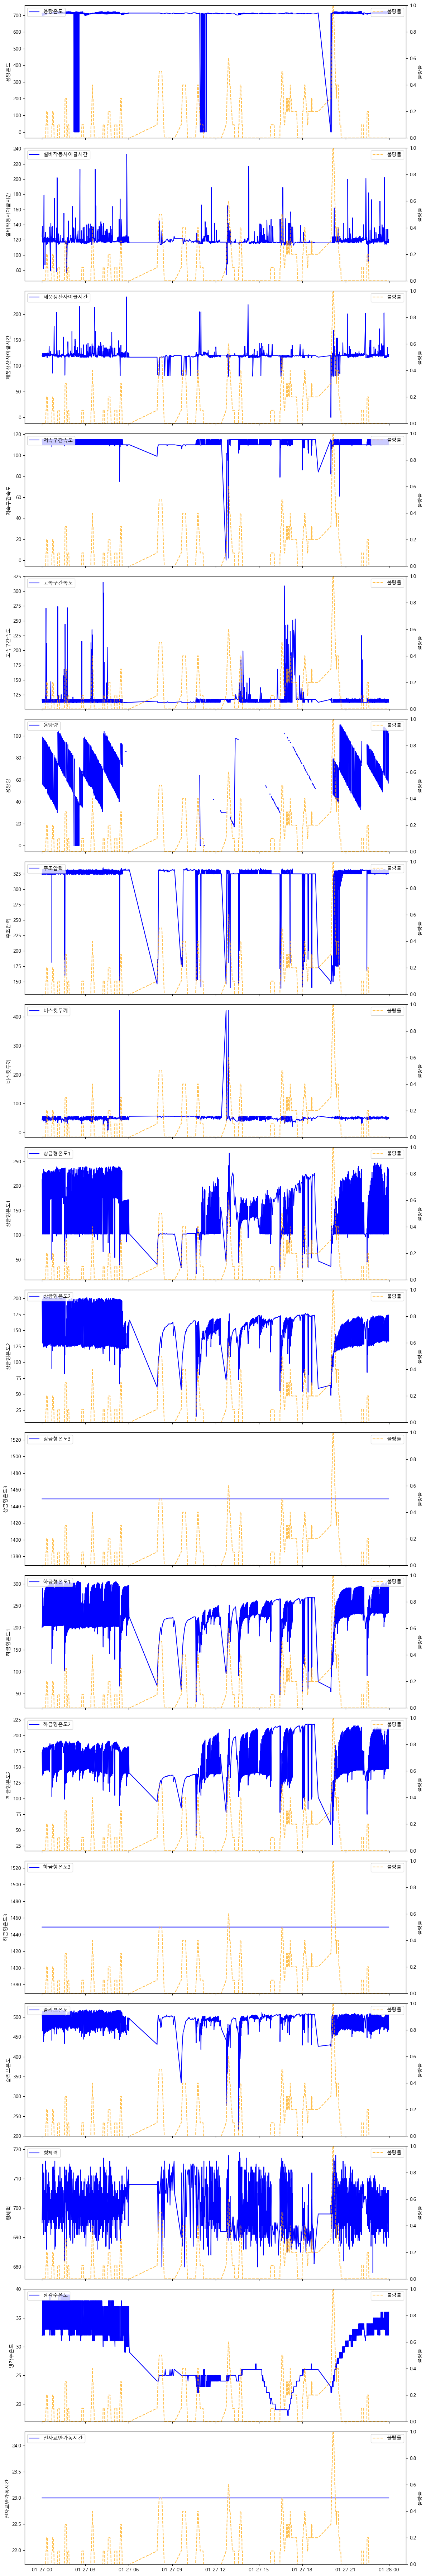

In [16]:
# 불량률과 수치형 변수 겹쳐 그리기
def plot_numeric_variables_and_defect_rate(df, defect_col, time_col, numeric_cols, date):
    # 특정 날짜에 해당하는 데이터 필터링
    df[time_col] = pd.to_datetime(df[time_col])
    daily_data = df[df[time_col].dt.date == pd.to_datetime(date).date()]

    # 불량률 계산 (불량 판정 열이 1일 때 불량으로 간주)
    daily_data['불량률'] = daily_data[defect_col].rolling(window=10, min_periods=1).mean()

    # 서브플롯 그리기 (한 줄에 2개의 그래프씩)
    num_vars = len(numeric_cols)
    fig, axes = plt.subplots(num_vars, 1, figsize=(12, 4 * num_vars), sharex=True)
    
    if num_vars == 1:
        axes = [axes]  # 1개일 경우 리스트로 변환

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        
        # 수치형 변수의 선 그래프
        ax.plot(daily_data[time_col], daily_data[col], label=col, color='blue')
        ax.set_ylabel(col)

        # 불량률 선 그래프 (이중 y축)
        ax2 = ax.twinx()
        ax2.plot(daily_data[time_col], daily_data['불량률'], label='불량률', color='orange', alpha=0.7, linestyle='--')
        ax2.set_ylabel('불량률')
        ax2.set_ylim(0, 1)  # 불량률은 0에서 1 사이로 고정

        # 범례 추가
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

    # X축에 시간 표시
    plt.xlabel('시간')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 예시 사용법
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plot_numeric_variables_and_defect_rate(eda_df, '불량판정', '등록일시', numeric_cols, '2019-01-27')


#### 전자교반가동시간 시각화

<Axes: xlabel='전자교반가동시간', ylabel='count'>

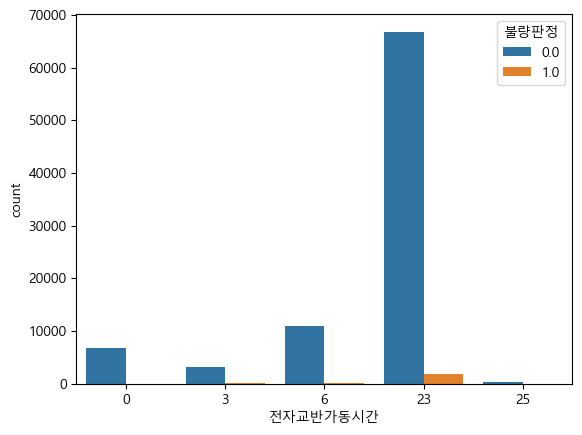

In [17]:
sns.countplot(data = eda_df, x = '전자교반가동시간', hue = '불량판정')

### **범주형 변수 시각화 및 가설검정**
- 가동 여부와 금형 코드에 따라 불량 판정이 달라짐
- 가열로와 불량 판정은 서로 독립적
#### 가동여부

In [18]:
df['가동여부'].value_counts()
pivot_working = df.pivot_table(index='가동여부', columns='불량판정', aggfunc='size', fill_value=0)
pivot_working

불량판정    0.0   1.0
가동여부             
가동    87996  2075
정지        2    22

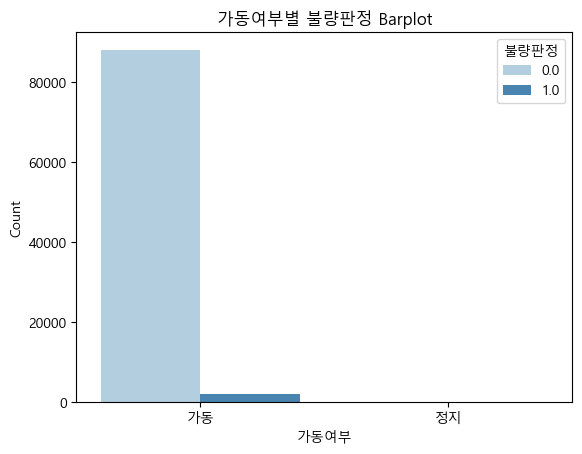

In [19]:
sns.countplot(data = eda_df, x = '가동여부', hue = '불량판정', palette='Blues')
# 그래프 제목 및 라벨 설정
plt.title('가동여부별 불량판정 Barplot')
plt.xlabel('가동여부')
plt.ylabel('Count')
plt.legend(title='불량판정')
plt.show()

In [20]:
import pandas as pd
from scipy.stats import chi2_contingency

# 교차표 생성
cross_tab = pd.crosstab(df['가동여부'], df['불량판정'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(cross_tab)

# 결과 출력
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
if p < 0.05:
    print("대립가설을 채택합니다: 가동여부에 따라 불량판정이 달라집니다.")
else:
    print("귀무가설을 채택합니다: 가동여부와 불량판정은 서로 독립적입니다.")

Chi-square statistic: 803.9806670106509
p-value: 7.35521086806699e-177
대립가설을 채택합니다: 가동여부에 따라 불량판정이 달라집니다.


### 금형코드

In [21]:
pivot_code = df.pivot_table(index = '금형코드', columns = '불량판정', aggfunc = 'size', fill_value=0)
pivot_code

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2004762812.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_code = df.pivot_table(index = '금형코드', columns = '불량판정', aggfunc = 'size', fill_value=0)


불량판정    0.0  1.0
금형코드            
8412  20727  256
8413   5808   20
8573   9176  420
8576    753    0
8600   2810  150
8722  18960  583
8917  29764  668

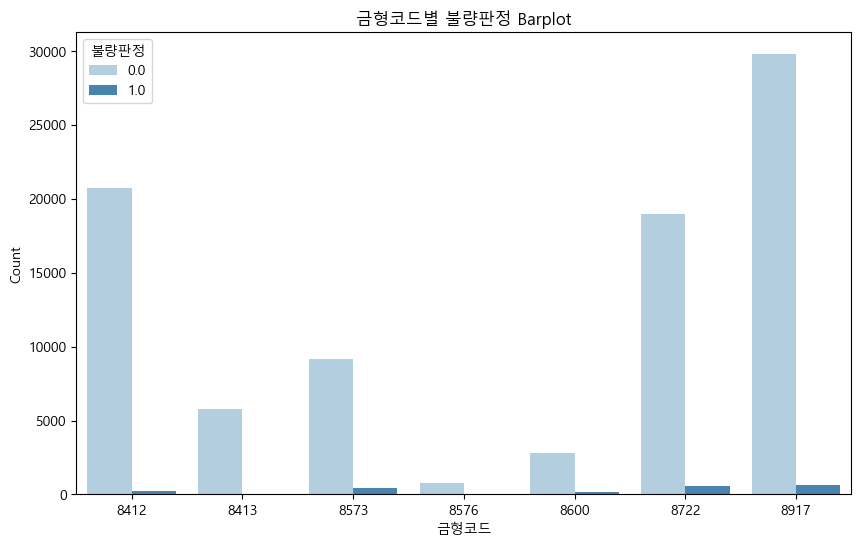

In [22]:
# 피벗 테이블을 barplot에 맞게 다시 변환
pivot_reset = pivot_code.reset_index().melt(id_vars='금형코드', value_vars=['0.0', '1.0'], var_name='불량판정', value_name='Count')

# barplot 그리기
plt.figure(figsize=(10,6))
sns.barplot(data=pivot_reset, x='금형코드', y='Count', hue='불량판정', palette='Blues')

# 그래프 제목 및 라벨 설정
plt.title('금형코드별 불량판정 Barplot')
plt.xlabel('금형코드')
plt.ylabel('Count')
plt.legend(title='불량판정')
plt.show()

In [23]:
import pandas as pd
from scipy.stats import chi2_contingency

# 교차표 생성
cross_tab = pd.crosstab(df['금형코드'], df['불량판정'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(cross_tab)

# 결과 출력
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
if p < 0.05:
    print("대립가설을 채택합니다: 금형코드에 따라 불량판정이 달라집니다.")
else:
    print("귀무가설을 채택합니다: 금형코드와 불량판정은 서로 독립적입니다.")

Chi-square statistic: 546.422420676845
p-value: 8.33729459584192e-115
대립가설을 채택합니다: 금형코드에 따라 불량판정이 달라집니다.


### 가열로

In [24]:
df['가열로'].value_counts()
df['가열로'] = df['가열로'].fillna('F')
pivot_heating = df.pivot_table(index='가열로', columns='불량판정', aggfunc='size', fill_value=0)
pivot_heating

불량판정    0.0   1.0
가열로              
A     20627   476
B     20454   535
F     46917  1086

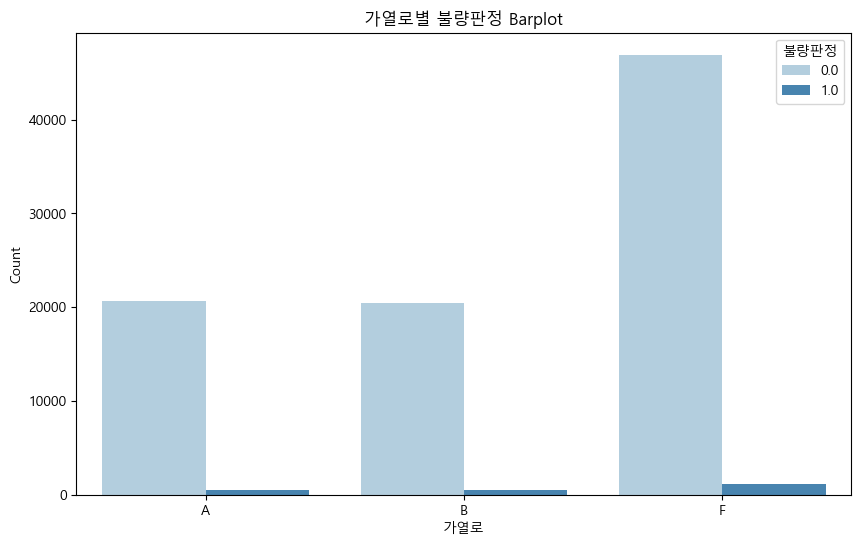

In [25]:
# 피벗 테이블을 barplot에 맞게 다시 변환
pivotreset_heating = pivot_heating.reset_index().melt(id_vars='가열로', value_vars=['0.0', '1.0'], var_name='불량판정', value_name='Count')

# barplot 그리기
plt.figure(figsize=(10,6))
sns.barplot(data=pivotreset_heating, x='가열로', y='Count', hue='불량판정', palette='Blues')

# 그래프 제목 및 라벨 설정
plt.title('가열로별 불량판정 Barplot')
plt.xlabel('가열로')
plt.ylabel('Count')
plt.legend(title='불량판정')
plt.show()

In [26]:
import pandas as pd
from scipy.stats import chi2_contingency

# 교차표 생성
cross_tab = pd.crosstab(df['가열로'], df['불량판정'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(cross_tab)

# 결과 출력
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
if p < 0.05:
    print("대립가설을 채택합니다: 가열로에 따라 불량판정이 달라집니다.")
else:
    print("귀무가설을 채택합니다: 가열로와 불량판정은 서로 독립적입니다.")

Chi-square statistic: 5.9036686583721965
p-value: 0.052243785699770964
귀무가설을 채택합니다: 가열로와 불량판정은 서로 독립적입니다.


### **전처리**
#### 결측치 처리

In [27]:
# 가열로, 용탕온도, 용탕량, 하금형온도, 상금형온도3에서 결측치 발견
df.isna().sum()

가동여부             0
용탕온도          2261
설비작동사이클시간        0
제품생산사이클시간        0
저속구간속도           0
고속구간속도           0
용탕량          44353
주조압력             0
비스킷두께            0
상금형온도1           0
상금형온도2           0
상금형온도3         312
하금형온도1           0
하금형온도2           0
하금형온도3         312
슬리브온도            0
형체력              0
냉각수온도            0
전자교반가동시간         0
불량판정             0
금형코드             0
가열로              0
dtype: int64

#### 용탕온도, 용탕량, 하금형온도3에 대해 선형 보간을 적용

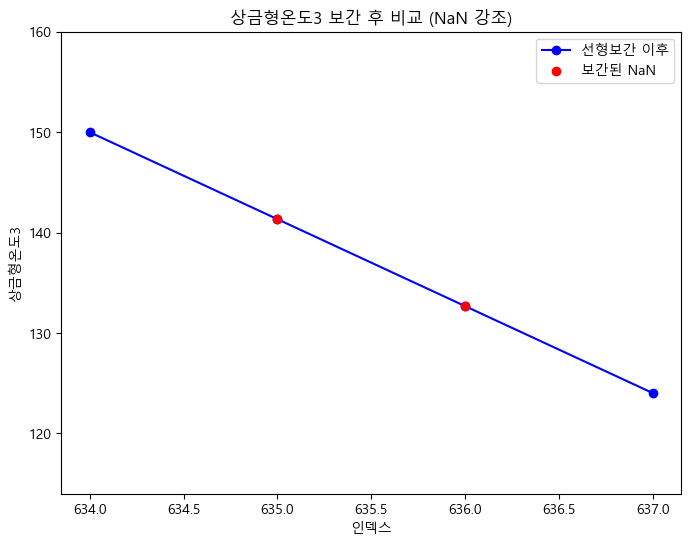

In [28]:
# 선형보간용 df2를 만듦
df2 = df.copy()

# 실제값, NaN, NaN, 실제값이 나오는 인덱스 출력
df2['상금형온도3'][634:638]

# 인덱스를 리셋해서 숫자형으로 만듦
df_reset = df2.reset_index(drop=True)

# 해당 구간 추출 (634~637 사용)
subset_df = df_reset.loc[634:637, ['상금형온도3']]

# 선형 보간 적용
subset_df['상금형온도3'] = subset_df['상금형온도3'].interpolate(method='linear')

# 보간된 결과 출력
subset_df

# 보간 전
#634   150.000000
#635   NaN
#636   NaN
#637   124.000000

# 보간 후
#634   150.000000
#635   141.333333
#636   132.666667
#637   124.000000

# 시각화
plt.figure(figsize=(8, 6))

# 선형 보간된 값을 선으로 연결하여 시각화
plt.plot(subset_df.index, subset_df['상금형온도3'], marker='o', linestyle='-', color='blue', label='선형보간 이후')

# NaN이었던 값들 강조 (보간된 값 표시)
plt.scatter([635, 636], subset_df.loc[[635, 636], '상금형온도3'], color='red', label='보간된 NaN', zorder=5)

# 그래프 축을 데이터 범위에 맞게 설정
plt.ylim(subset_df['상금형온도3'].min() - 10, subset_df['상금형온도3'].max() + 10)

# 라벨 설정
plt.xlabel('인덱스')
plt.ylabel('상금형온도3')
plt.title('상금형온도3 보간 후 비교 (NaN 강조)')

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

In [29]:
df['용탕온도'] = df['용탕온도'].interpolate(method='linear', limit_direction='both')
df['용탕량'] = df['용탕량'].interpolate(method='linear', limit_direction='both')
df['하금형온도3'] = df['하금형온도3'].interpolate(method='linear', limit_direction='both')
df['상금형온도3'] = df['상금형온도3'].interpolate(method='linear', limit_direction='both')
df.isna().sum()

가동여부         0
용탕온도         0
설비작동사이클시간    0
제품생산사이클시간    0
저속구간속도       0
고속구간속도       0
용탕량          0
주조압력         0
비스킷두께        0
상금형온도1       0
상금형온도2       0
상금형온도3       0
하금형온도1       0
하금형온도2       0
하금형온도3       0
슬리브온도        0
형체력          0
냉각수온도        0
전자교반가동시간     0
불량판정         0
금형코드         0
가열로          0
dtype: int64

#### 이상치 제거 

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2821225926.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2821225926.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2821225926.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, palette='Set2')
C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2821225926.py:21: FutureWarning: 

Passing `palette` without assign

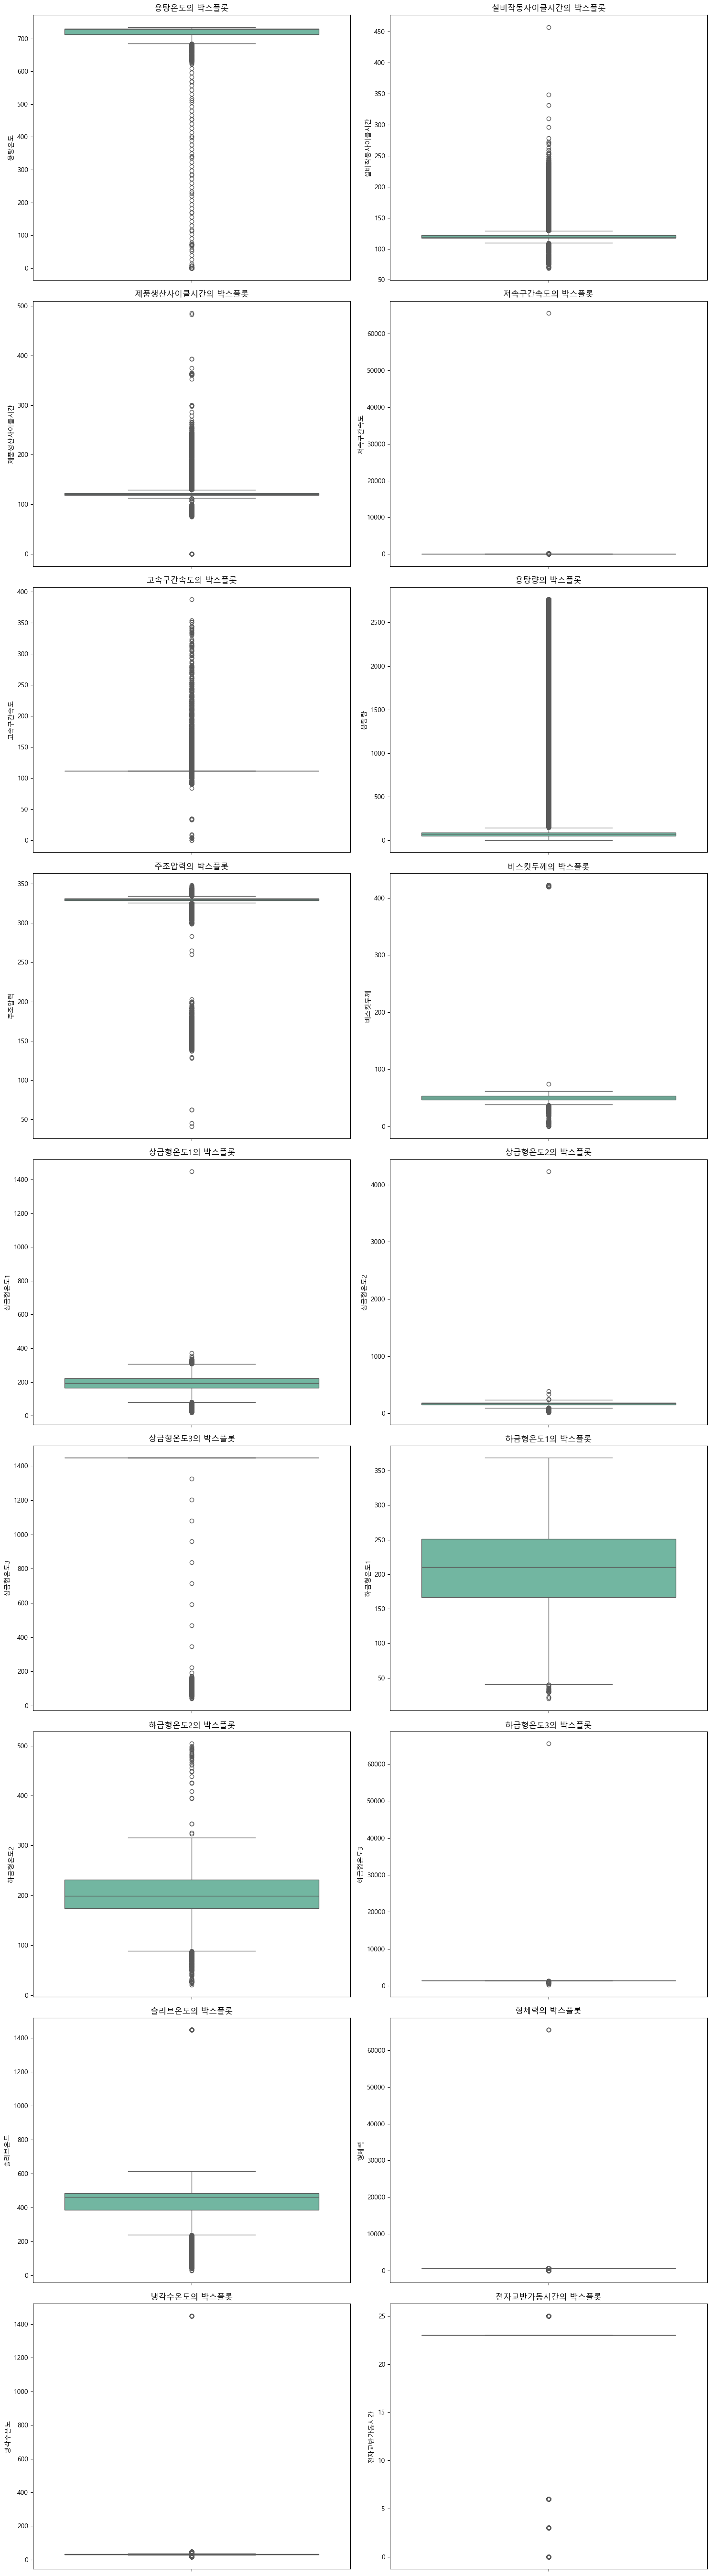

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 수치형 변수들에 대한 박스플롯을 서브플롯으로 그리는 함수
def boxplot_subplots(df):
    # 수치형 변수 선택 (int64와 float64 타입만 선택)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns  
    
    # 서브플롯 행 계산 (한 행에 2개의 서브플롯 배치)
    total_plots = len(numeric_cols)  # 각 변수당 1개의 플롯
    max_cols = 2  # 한 행에 2개의 서브플롯
    max_rows = int(np.ceil(total_plots / max_cols))  # 행 개수 계산
    
    plt.figure(figsize=(15, 6 * max_rows))  # 전체 플롯 크기 설정
    
    plot_index = 1
    for col in numeric_cols:
        # 각 변수에 대해 하나의 박스플롯 그리기
        plt.subplot(max_rows, max_cols, plot_index)
        sns.boxplot(data=df, y=col, palette='Set2')
        plt.title(f'{col}의 박스플롯', fontsize=12)
        plt.ylabel(col, fontsize=10)
        plt.xticks(rotation=90)
        plot_index += 1
    
    plt.tight_layout()  # 서브플롯 간의 간격 조정
    plt.show()

# 박스플롯 그리기
boxplot_subplots(df)

In [31]:
df = df[df['설비작동사이클시간'] <= 400] # 1
df = df[df['제품생산사이클시간'] <= 450] # 2
df = df[df['저속구간속도'] <= 60000] # 1
df = df[df['상금형온도1'] <= 1400] # 1
df = df[df['상금형온도2'] <= 4000] # 1
df = df[df['하금형온도3'] <= 60000] # 1
df = df[df['형체력'] <= 60000] # 3
df = df[df['냉각수온도'] <= 1400] # 9

#### 변수간 상관관계 확인하기

c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\USER\DS\Miniconda\envs\ls_env\L

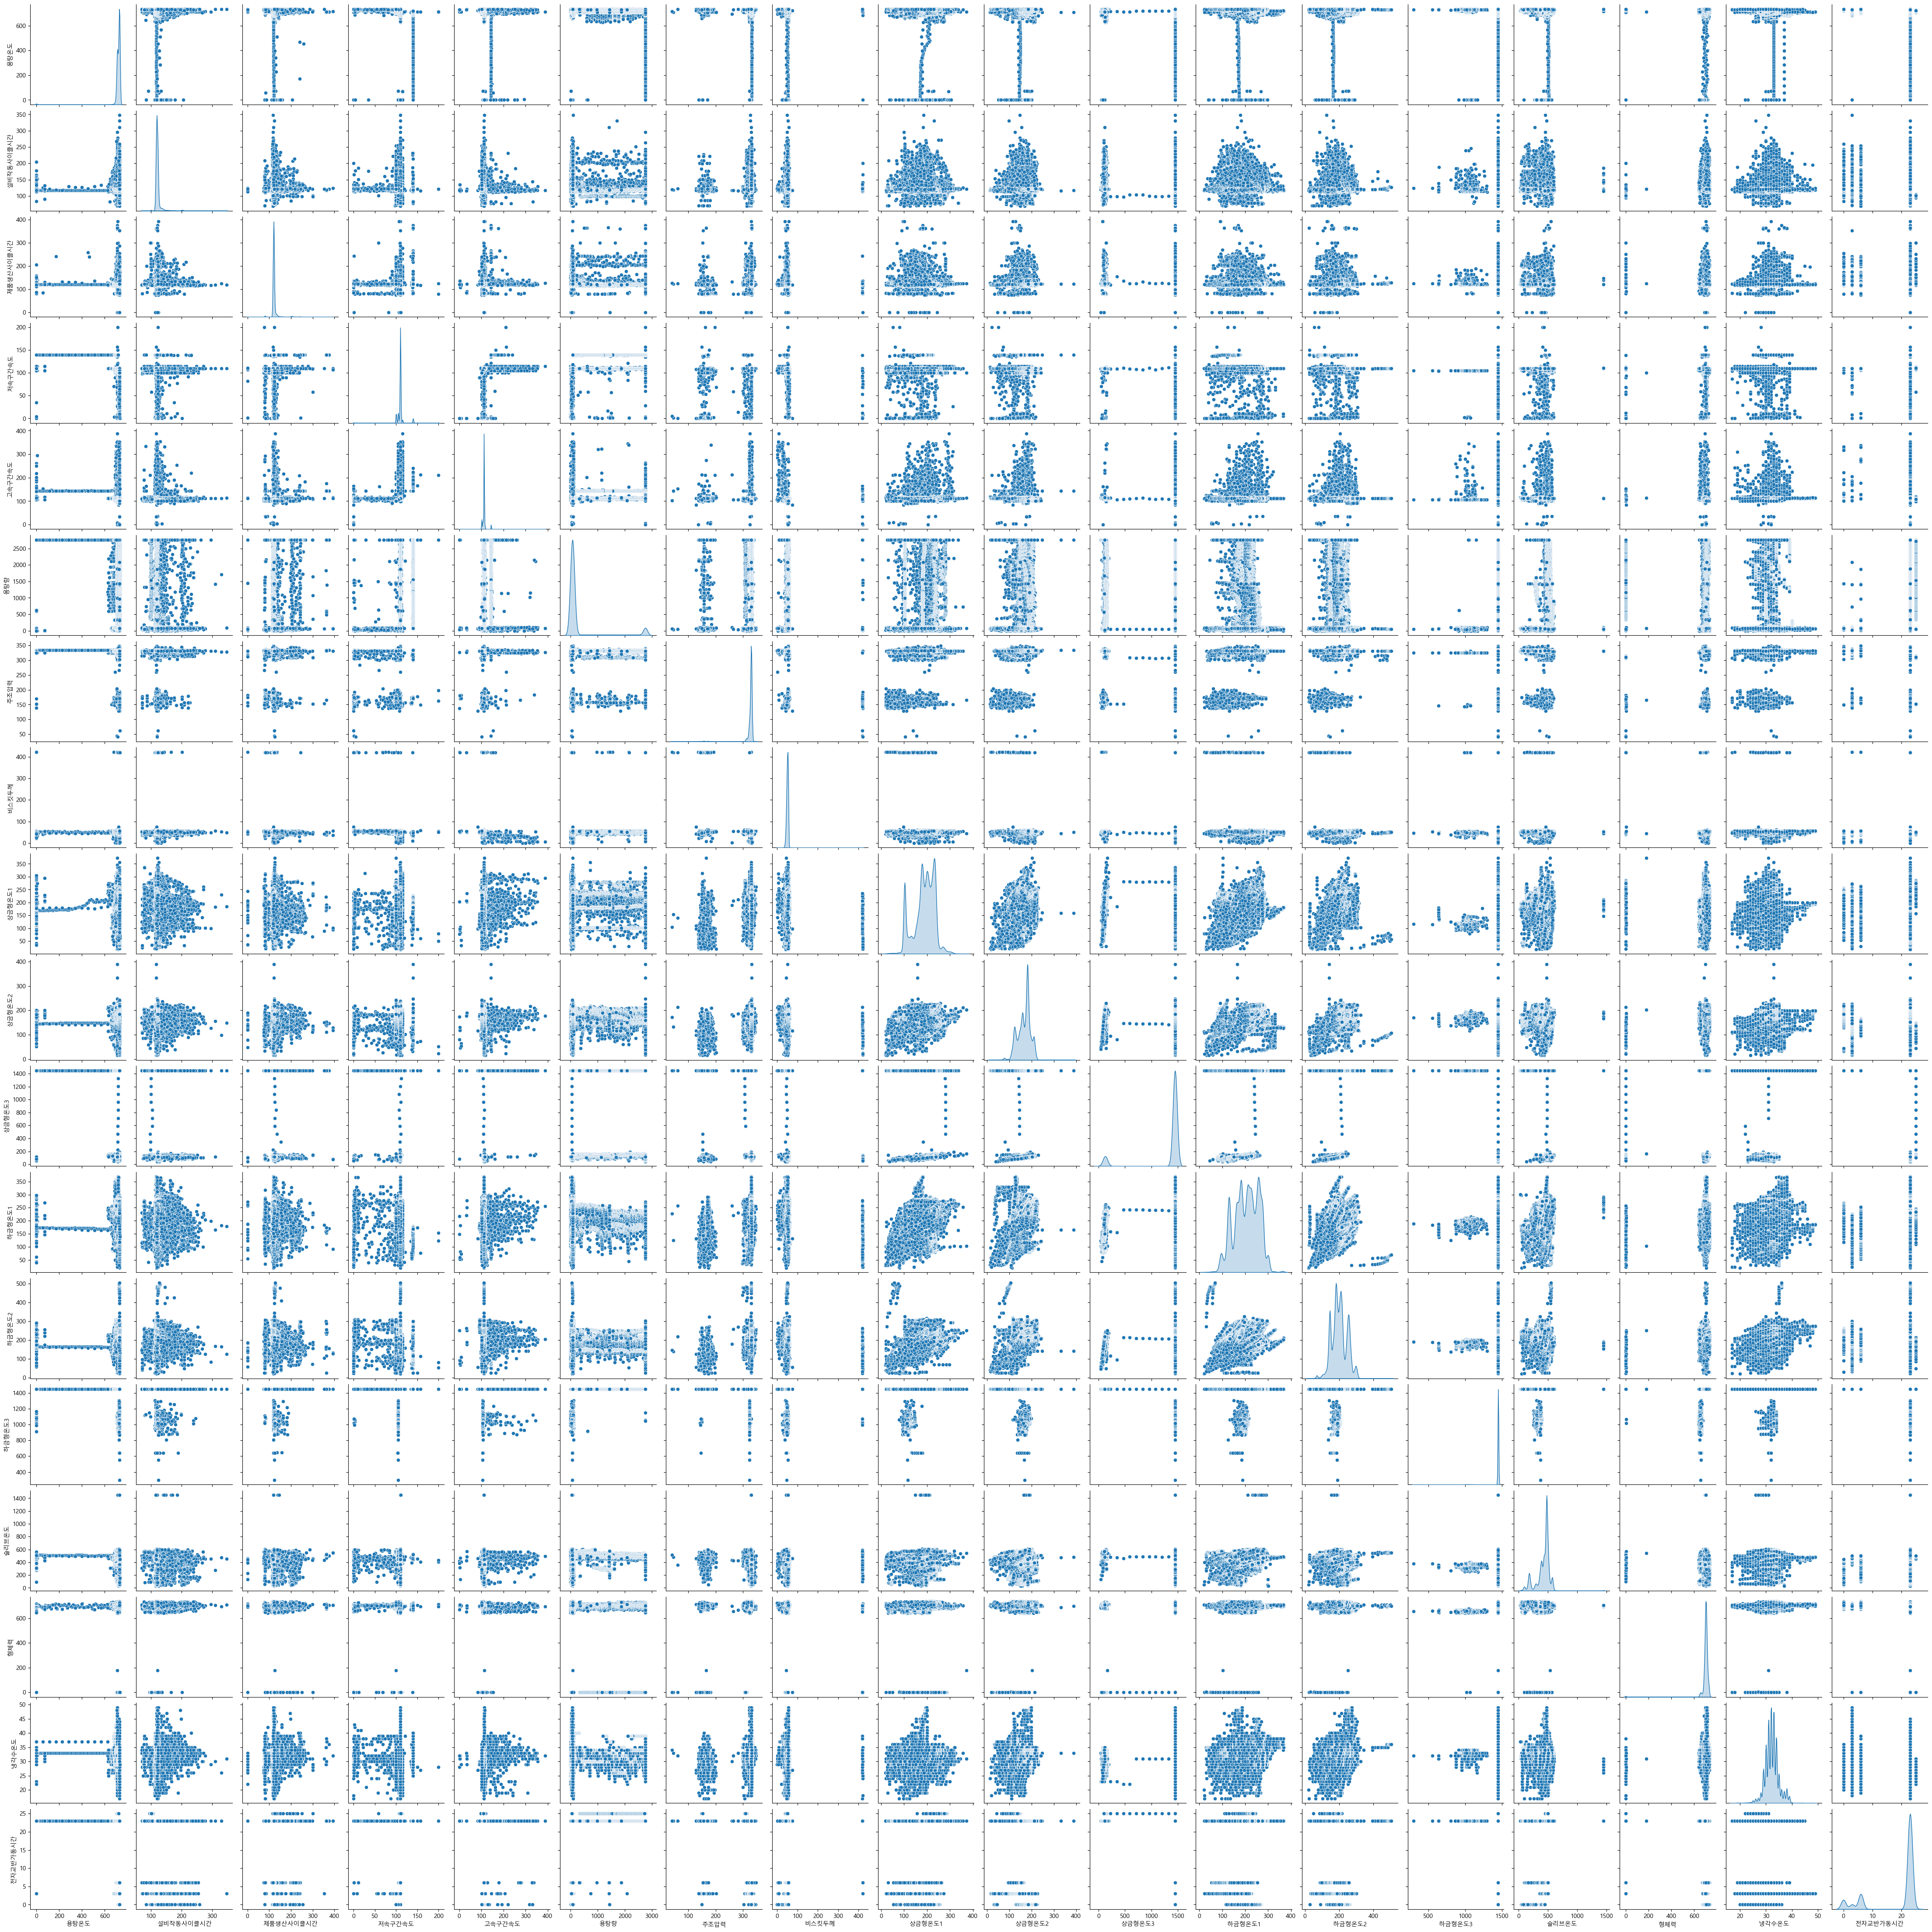

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수 간의 pairplot 그리기
def num_pairplot(df, palette='dark', diag_kind='kde'):
    numeric_cols = df.select_dtypes(include=['number']).columns  # 수치형 변수 선택
    sns.pairplot(df[numeric_cols], palette=palette, diag_kind=diag_kind)
    plt.show()

# 함수 호출
num_pairplot(df)


c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


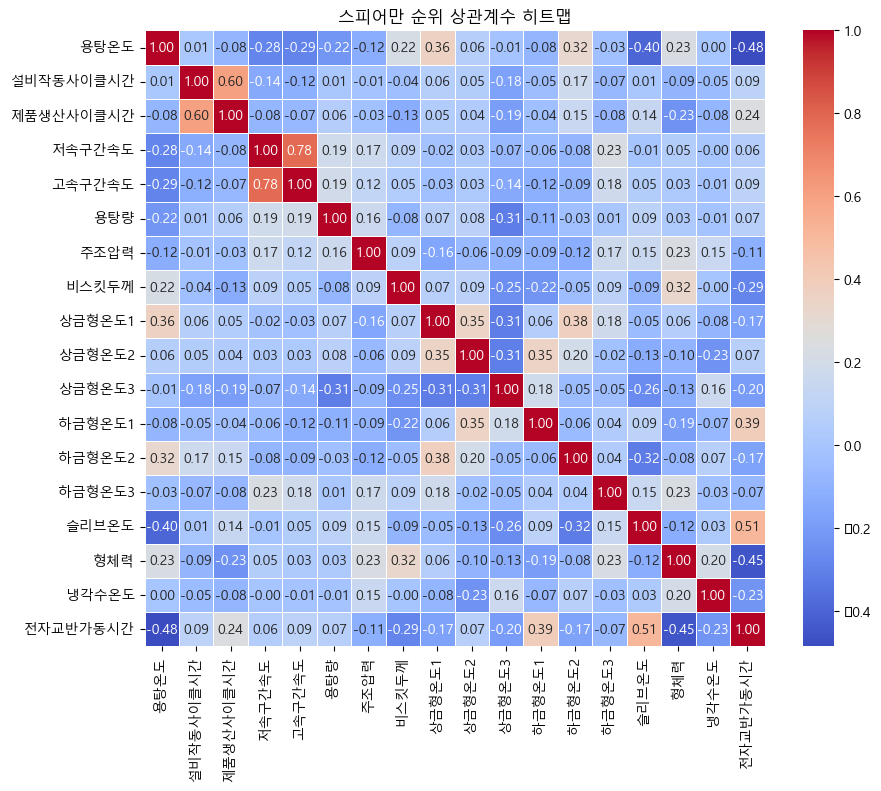

In [33]:
def plot_spearman_corr(df):
    # 수치형 변수만 선택
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # 스피어만 상관계수 계산
    spearman_corr = df[numeric_cols].corr(method='spearman')
    
    # 히트맵으로 상관계수 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('스피어만 순위 상관계수 히트맵')
    plt.show()

# 함수 호출
plot_spearman_corr(df)


In [34]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산 함수
def calculate_vif(df):
    # 수치형 변수 선택
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # VIF 계산을 위해 상수항을 추가 (intercept)
    X = df[numeric_cols].dropna()  # 결측치 제거
    X = sm.add_constant(X)
    
    # VIF 데이터프레임 생성
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X.columns
    
    # VIF 값 계산
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# VIF 계산 및 출력
vif_result = calculate_vif(df)
vif_result



Variable          VIF
0       const  1870.469874
1        용탕온도     1.025817
2   설비작동사이클시간     1.025921
3   제품생산사이클시간     1.030336
4      저속구간속도     1.843058
5      고속구간속도     1.472905
6         용탕량     1.723629
7        주조압력     1.231161
8       비스킷두께     1.308164
9      상금형온도1     1.529122
10     상금형온도2     1.618427
11     상금형온도3     1.866216
12     하금형온도1     1.830973
13     하금형온도2     1.407454
14     하금형온도3     1.129816
15      슬리브온도     2.034547
16        형체력     1.175121
17      냉각수온도     1.184101
18   전자교반가동시간     2.290676

### **IV(Information Value)**

In [35]:
# 랜덤 시드 설정
np.random.seed(42)
df['불량판정'] = pd.to_numeric(df['불량판정'], errors='coerce')

#### 주조압력 IV

In [36]:
def 동일_데이터_구간_나누기(df, column, num_bins=10):
    # 데이터 수 동일한 구간으로 나누기 (중복 허용)
    df['구간'] = pd.qcut(df[column].rank(method='first'), q=num_bins, labels=False)

    # 각 구간에 대한 통계 정보 계산
    grouped = df.groupby('구간').apply(lambda x: pd.Series({
        '데이터 건수': len(x),
        '불량판정 0 개수': (x['불량판정'] == 0).sum(),
        '불량판정 1 개수': (x['불량판정'] == 1).sum()
    })).reset_index()

    # WOE와 IV 계산
    total_good = df['불량판정'].value_counts()[0]
    total_bad = df['불량판정'].value_counts()[1]

    # 각 구간의 비율 계산
    grouped['불량판정 0 비율'] = grouped['불량판정 0 개수'] / total_good
    grouped['불량판정 1 비율'] = grouped['불량판정 1 개수'] / total_bad

    # WOE 계산
    grouped['WOE'] = np.log(grouped['불량판정 1 비율'] / grouped['불량판정 0 비율'].replace(0, np.nan))

    # IV 계산
    grouped['IV'] = (grouped['불량판정 1 비율'] - grouped['불량판정 0 비율']) * grouped['WOE']
    iv_value = grouped['IV'].sum()  # 전체 IV 값

    # 수치 범위 추가
    grouped['수치 범위'] = grouped.apply(lambda x: f"{df[df['구간'] == x['구간']][column].min()} - {df[df['구간'] == x['구간']][column].max()}", axis=1)

    # 수치 범위를 첫 번째 열로 이동
    grouped = grouped[['수치 범위', '구간', '데이터 건수', '불량판정 0 개수', '불량판정 1 개수', 
                       '불량판정 0 비율', '불량판정 1 비율', 'WOE', 'IV']]

    return grouped, iv_value

result, total_iv = 동일_데이터_구간_나누기(df, '주조압력', num_bins=10)
result

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\463570837.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('구간').apply(lambda x: pd.Series({


수치 범위  구간  데이터 건수  불량판정 0 개수  불량판정 1 개수  불량판정 0 비율  불량판정 1 비율  \
0   41.0 - 324.0   0    9008       7563       1445   0.085954   0.692381   
1  324.0 - 325.0   1    9008       8893        115   0.101069   0.055103   
2  325.0 - 329.0   2    9007       8960         47   0.101831   0.022520   
3  329.0 - 330.0   3    9008       8982         26   0.102081   0.012458   
4  330.0 - 330.0   4    9007       8930         77   0.101490   0.036895   
5  330.0 - 331.0   5    9008       8978         30   0.102035   0.014375   
6  331.0 - 331.0   6    9007       8890        117   0.101035   0.056061   
7  331.0 - 332.0   7    9008       8903        105   0.101183   0.050311   
8  332.0 - 332.0   8    9007       8974         33   0.101990   0.015812   
9  332.0 - 348.0   9    9008       8916         92   0.101331   0.044082   

        WOE        IV  
0  2.086326  1.265205  
1 -0.606603  0.027883  
2 -1.508894  0.119671  
3 -2.103397  0.188512  
4 -1.011882  0.065362  
5 -1.959851  0.171802  
6 -0.589024  0.026491  
7 -0.698699  0.035544  
8 -1.864095  0.160644  
9 -0.832330  0.047650

#### 전체 변수 IV
- 공정 최적화를 위해 관리해야 할V값 상위 3개 변수를 선정: 주조압력, 하금형온도2, 하금형온도1

In [37]:
import pandas as pd
import numpy as np

# IV 계산 함수 (범주형 및 수치형 변수를 모두 처리)
def calculate_iv(df, target, cat_cols):
    iv_dict = {}
    
    # 타겟 변수를 숫자로 변환 (필요한 경우)
    df[target] = pd.to_numeric(df[target], errors='coerce')  # 불량판정 열을 숫자형으로 변환

    total_events = df[target].sum()  # 타겟이 1인 경우의 총합 (이벤트)
    total_non_events = df[target].count() - total_events  # 타겟이 0인 경우의 총합 (비이벤트)
    
    # 범주형 변수 처리
    for col in cat_cols:
        # 각 범주별 이벤트와 비이벤트 수 계산
        grouped = df.groupby(col)[target].agg(['count', 'sum']).reset_index()
        grouped.columns = [col, 'total', 'events']
        
        # 비이벤트 수 계산
        grouped['non_events'] = grouped['total'] - grouped['events']
        
        # WOE 및 IV 계산
        grouped['event_rate'] = grouped['events'] / total_events
        grouped['non_event_rate'] = grouped['non_events'] / total_non_events
        grouped['WOE'] = np.log(grouped['event_rate'] / grouped['non_event_rate']).replace([np.inf, -np.inf], 0)  # 무한대 처리
        grouped['IV'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['WOE']
        
        # IV 값 계산
        iv = grouped['IV'].sum()
        iv_dict[col] = iv
    
    # 수치형 변수 처리
    for col in df.select_dtypes(include=[np.number]).columns:
        if col == target:  # 타겟 변수를 제외
            continue

        # 데이터를 10개 구간으로 나누기
        df['ranked'] = df[col].rank(method='first')
        df['bin'] = pd.qcut(df['ranked'], 10, labels=False, duplicates='drop')

        # 각 구간에 대한 이벤트와 비이벤트 수 계산
        grouped = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
        grouped.columns = ['bin', 'total', 'events']
        
        # 비이벤트 계산
        grouped['non_events'] = grouped['total'] - grouped['events']
        
        # WOE 및 IV 계산
        grouped['event_rate'] = grouped['events'] / total_events
        grouped['non_event_rate'] = grouped['non_events'] / total_non_events
        grouped['WOE'] = np.log(grouped['event_rate'] / grouped['non_event_rate']).replace([np.inf, -np.inf], 0)
        grouped['IV'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['WOE']
        
        # IV 값 계산
        iv = grouped['IV'].sum()
        iv_dict[col] = iv

    return iv_dict

# 범주형 변수 리스트
cat_cols = ['가동여부', '가열로', '금형코드']

# IV 값 계산
iv_values = calculate_iv(df, '불량판정', cat_cols)

# 결과 출력
iv_values_df = pd.DataFrame(list(iv_values.items()), columns=['Variable', 'IV'])
iv_values_df = iv_values_df.sort_values(by='IV', ascending=False)
iv_values_df


C:\Users\USER\AppData\Local\Temp\ipykernel_5392\3506130460.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(col)[target].agg(['count', 'sum']).reset_index()
c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Variable        IV
21         구간  2.108765
9        주조압력  2.108765
12     상금형온도2  1.313650
15     하금형온도2  1.259787
6      저속구간속도  0.946738
14     하금형온도1  0.856938
11     상금형온도1  0.807636
13     상금형온도3  0.786041
16     하금형온도3  0.769850
19      냉각수온도  0.650283
7      고속구간속도  0.601471
20   전자교반가동시간  0.592864
17      슬리브온도  0.308596
2        금형코드  0.305565
18        형체력  0.252207
10      비스킷두께  0.222068
3        용탕온도  0.200379
5   제품생산사이클시간  0.137861
8         용탕량  0.116504
0        가동여부  0.061271
4   설비작동사이클시간  0.031382
1         가열로  0.003093

#### IV 상위 3개 변수 불량률 계산

In [154]:
def 구간별_불량_통계(df, column):
    # 최소값과 최대값 기준으로 10개 구간 정의
    min_value = df[column].min()
    max_value = df[column].max()
    bins = np.linspace(min_value, max_value, num=11)  # 10개 구간을 나누기 위해 11개의 경계 값 생성
    
    # 수치형 변수를 10개 구간으로 나누기
    df['구간'] = pd.cut(df[column], bins=bins, include_lowest=True)

    # 각 구간에 대한 통계 정보 계산
    grouped = df.groupby('구간').apply(lambda x: pd.Series({
        '데이터 수': len(x),
        '불량 갯수 (1)': (x['불량판정'] == 1).sum()
    })).reset_index()

    # 불량률 계산
    grouped['불량률'] = grouped['불량 갯수 (1)'] / grouped['데이터 수'] * 100
    grouped['불량률'] = grouped['불량률'].round(3)
    grouped['불량률'] = grouped['불량률'].astype(str) + '%'

    # 수치 범위 추가
    grouped['수치 범위'] = grouped['구간'].astype(str)

    # 최종 결과 정리
    결과 = grouped[['수치 범위', '데이터 수', '불량 갯수 (1)', '불량률']]

    return 결과

result1 = 구간별_불량_통계(df, '주조압력')
result1
result2 = 구간별_불량_통계(df, '상금형온도2')
result2
result3 = 구간별_불량_통계(df, '하금형온도2')
result3

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2740570448.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2740570448.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\2740570448.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 

수치 범위  데이터 수  불량 갯수 (1)      불량률
0  (20.999, 69.3]    206        105  50.971%
1   (69.3, 117.6]   1408        543  38.565%
2  (117.6, 165.9]  16748        675    4.03%
3  (165.9, 214.2]  40982        525   1.281%
4  (214.2, 262.5]  23812        120   0.504%
5  (262.5, 310.8]   6870        102   1.485%
6  (310.8, 359.1]     22          4  18.182%
7  (359.1, 407.4]      2          1    50.0%
8  (407.4, 455.7]      6          4  66.667%
9  (455.7, 504.0]     20          8    40.0%

In [155]:
result1

수치 범위  데이터 수  불량 갯수 (1)      불량률
0  (40.999, 71.7]      3          3   100.0%
1   (71.7, 102.4]      0          0     nan%
2  (102.4, 133.1]      2          2   100.0%
3  (133.1, 163.8]    747        727  97.323%
4  (163.8, 194.5]    576        571  99.132%
5  (194.5, 225.2]     11         11   100.0%
6  (225.2, 255.9]      0          0     nan%
7  (255.9, 286.6]      3          3   100.0%
8  (286.6, 317.3]   2643         71   2.686%
9  (317.3, 348.0]  86091        699   0.812%

#### 전체 조건 만족시 불량률의 감소율

In [39]:
num= df.shape[0] # 기존 데이터 90076개
num_def = df['불량판정'].value_counts()[1] # 기존 불량 2087
def_rate = round((num_def / num) * 100, 3) # 기존 불량률 2.317%

df_opt = df.query('주조압력>286.6 & 상금형온도2>127.2 & 상금형온도2<=239.4 & 하금형온도2>117.6 & 하금형온도2<=310.8')
num_opt = df_opt.shape[0] # 최적화 후 데이터 77412개
num_opt_def = df_opt['불량판정'].value_counts()[1]  # 최적화 후 불량 397개
def_rate_opt = round((num_opt_def / num_opt) * 100, 3) # 최적화 후 불량률 0.513%

dec_rate = round(((def_rate - def_rate_opt) / def_rate) * 100, 3)# 불량률의 감소율 77.859%

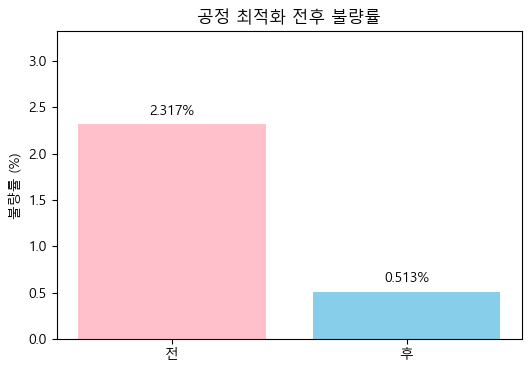

In [40]:
labels = ['전', '후']
values = [def_rate, def_rate_opt]

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['pink', 'skyblue'])

plt.title('공정 최적화 전후 불량률')
plt.ylabel('불량률 (%)')

plt.ylim(0, max(def_rate, def_rate_opt) + 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.1, f'{v:.3f}%', ha='center')

plt.show()

### **Decision Tree**

In [41]:
df = df.drop(['구간', 'ranked', 'bin'], axis = 1)

In [42]:
# '가동여부' 변환: 가동이면 0, 아니면 1
df['가동여부'] = df['가동여부'].apply(lambda x: 0 if x == '가동' else 1)


# '가열로', '금형코드' 칼럼 더미변수로 인코딩
df = pd.get_dummies(df, columns = ["가열로", "금형코드"], drop_first = True)

C:\Users\USER\AppData\Local\Temp\ipykernel_5392\3686603071.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette="coolwarm")


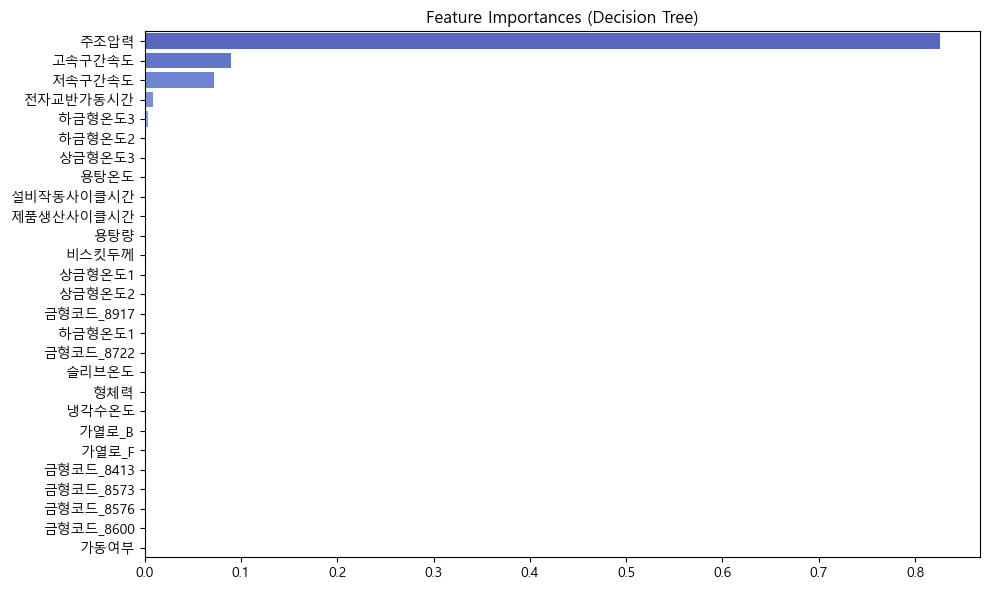

In [43]:
# 변수 중요도 시각화
# model fit을 위한 X, y 분류
X = df.drop("불량판정", axis = 1)
y = df["불량판정"]

# Decision Tree 모델 학습
dt_model = DecisionTreeClassifier(random_state= 42, max_depth=3)

dt_model.fit(X, y)
plt.figure(figsize=(10, 6))
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지
plt.title('Feature Importances (Decision Tree)')
sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette="coolwarm")
plt.tight_layout()
plt.show()

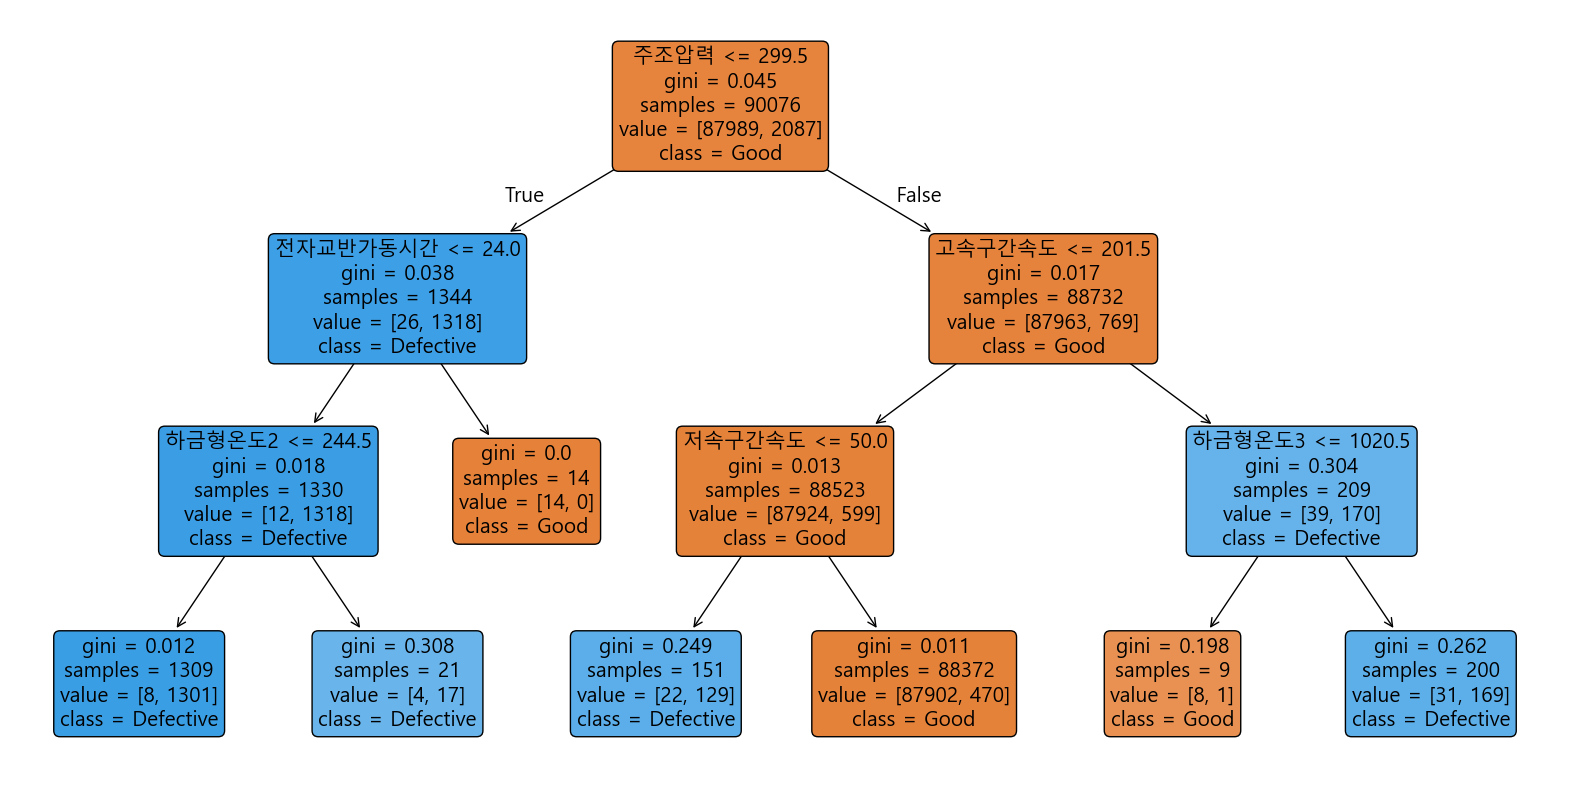

In [44]:
# 트리 시각화
plt.figure(figsize=(20, 10))  # 그림 크기 설정
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=['Good', 'Defective'], rounded=True)
plt.show()

# Clustering

In [187]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

## KNN

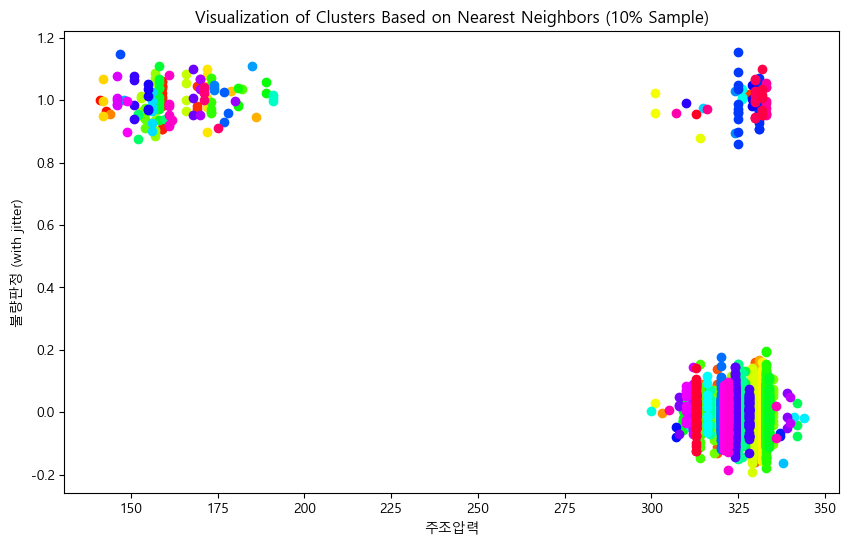

In [257]:
# 데이터의 10% 샘플링 (비율 유지)
df_sample, _ = train_test_split(df, test_size=0.9, stratify=df['불량판정'], random_state=42)

# 군집 분석에 사용할 변수 선택 (주조압력과 불량판정)
df_knn = df_sample[['주조압력', '불량판정']]

# KNN 모델 설정 및 학습
neighbors = NearestNeighbors(n_neighbors=250)
neighbors_fit = neighbors.fit(df_knn)

# 각 데이터 포인트에 대한 이웃 거리 및 인덱스 계산
distances, indices = neighbors_fit.kneighbors(df_knn)

# 클러스터 레이블 생성 (첫 번째 이웃의 인덱스를 기준으로 그룹을 나눔)
groups = np.unique(indices[:, 1])
group_labels = np.zeros(df_knn.shape[0], dtype=int)
for group in groups:
    group_labels[indices[:, 1] == group] = group

# 불량판정을 숫자형으로 변환 후 지터 추가
y_jitter = df_sample['불량판정'].astype(float) + np.random.normal(0, 0.05, size=df_sample['불량판정'].shape)

# 색상 설정 및 시각화
num_groups = len(np.unique(group_labels))
palette = sns.color_palette("hsv", num_groups)  # 색상 수를 클러스터 수에 맞춤
plt.figure(figsize=(10, 6))
for i, group in enumerate(np.unique(group_labels)):
    plt.scatter(df_knn[group_labels == group]['주조압력'], y_jitter[group_labels == group], label=f'Group {group}', color=palette[i])


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.title('Visualization of Clusters Based on Nearest Neighbors (10% Sample)')
plt.xlabel('주조압력')
plt.ylabel('불량판정 (with jitter)')
# plt.legend()
plt.show()

## DBSCAN

### 주조압력 내림차순 하여 변곡점 보기 

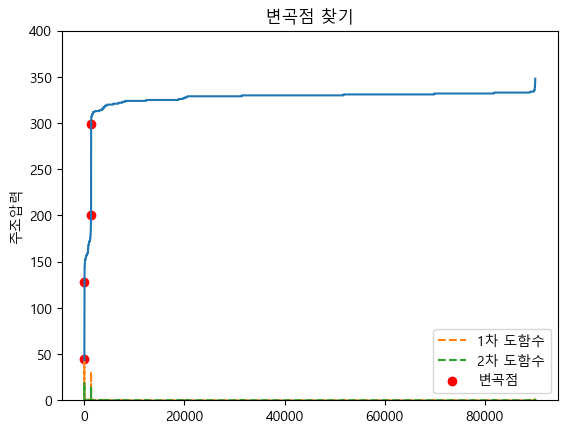

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# '주조압력'과 '불량판정' 데이터를 정렬된 상태로 불러오기
pressure_sorted = df[['주조압력', '불량판정']].sort_values('주조압력', ascending=True).reset_index(drop=True)

# '주조압력'과 '불량판정' 변수 추출
x = pressure_sorted['불량판정'].index
y = pressure_sorted['주조압력'].values

# 1차 도함수와 2차 도함수 계산
dy = np.gradient(y, x)  # 1차 도함수 (불량판정에 대한 주조압력의 변화율)
d2y = np.gradient(dy, x)  # 2차 도함수

# 변곡점 찾기 (2차 도함수가 크게 변화하는 지점)
inflection_points, _ = find_peaks(np.abs(d2y), prominence=1)  # prominence는 필요에 따라 조정

# 결과 시각화
plt.plot(x, y)
plt.plot(x, dy, '--', label='1차 도함수')
plt.plot(x, d2y, '--', label='2차 도함수')
plt.scatter(x[inflection_points], y[inflection_points], color='red', label='변곡점')
plt.ylabel("주조압력")
plt.ylim(0, 400)
plt.legend()
plt.title("변곡점 찾기")
plt.show()


In [214]:
inflection_points

array([   1,    3, 1337, 1342], dtype=int64)

In [218]:
print(pressure_sorted.iloc[1])
print(pressure_sorted.iloc[3])
print(pressure_sorted.iloc[1337])
print(pressure_sorted.iloc[1342])

주조압력    45.0
불량판정     1.0
Name: 1, dtype: float64
주조압력    128.0
불량판정      1.0
Name: 3, dtype: float64
주조압력    200.0
불량판정      1.0
Name: 1337, dtype: float64
주조압력    299.0
불량판정      1.0
Name: 1342, dtype: float64


In [252]:
np.random.seed(42)
## epsilon 0.5
# elbow 지점을 찾아 적절한 eps 값 선택
epsilon_value = 1  # elbow 그래프에서 찾은 값으로 설정

# 3. min_samples 값 설정
n_value = int(np.log(len(df)))  # 데이터 개수의 자연로그로 설정

# 4. DBSCAN 모델 생성 및 클러스터링 수행
dbscan = DBSCAN(eps=epsilon_value, min_samples=n_value, metric = 'euclidean')
clusters = dbscan.fit_predict(df[['불량판정', '주조압력']])

# 클러스터링 결과 저장 및 분석을 위해 df에 추가
df['Cluster'] = clusters

In [253]:
df['Cluster'].value_counts()

Cluster
 0    88731
 1     1303
-1       23
 2       19
Name: count, dtype: int64

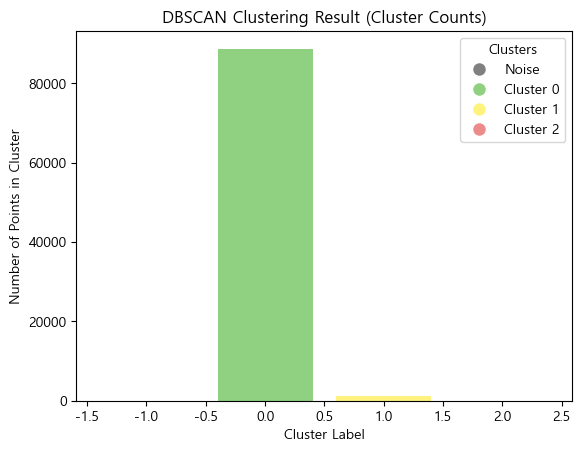

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# DBSCAN 클러스터 결과 예시 (unique와 counts를 이용한 색상 변경 코드)
unique, counts = np.unique(clusters, return_counts=True)

# 클러스터별 색상 지정
colors = ["#8fd081", "#fff27e", "#eb8b8b"]  # 노이즈와 각 클러스터에 해당하는 색상

# 막대그래프 시각화
plt.bar(unique, counts, color=[colors[label] for label in unique])
plt.xlabel("Cluster Label")
plt.ylabel("Number of Points in Cluster")
plt.title("DBSCAN Clustering Result (Cluster Counts)")

# 범례 설정
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Noise', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Cluster 0', markerfacecolor="#8fd081", markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor="#fff27e", markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Cluster 2', markerfacecolor="#eb8b8b", markersize=10)
]

plt.legend(handles=legend_elements, title="Clusters", loc="best")
plt.show()

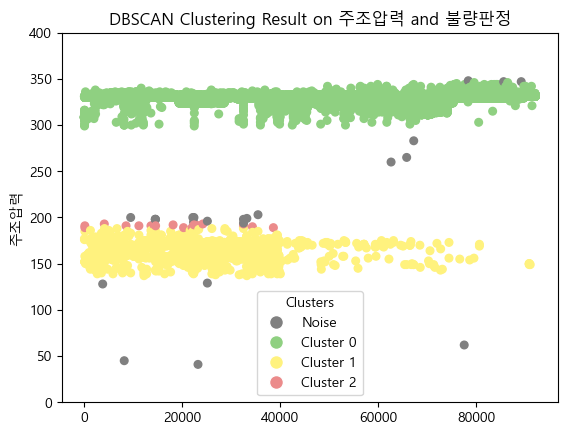

In [256]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

unique_clusters = np.unique(clusters)
colors = ListedColormap(["gray", "#8fd081", "#fff27e", "#eb8b8b"])
plt.scatter(df.index, df['주조압력'], c=clusters, cmap=colors, marker='o', s = 30)
plt.ylabel("주조압력")
plt.title("DBSCAN Clustering Result on 주조압력 and 불량판정")

legend_elements = [
 Line2D([0], [0], marker='o', color='w', label='Noise', markerfacecolor='gray', markersize=10),
 Line2D([0], [0], marker='o', color='w', label='Cluster 0', markerfacecolor="#8fd081", markersize=10),
 Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor="#fff27e", markersize=10),
 Line2D([0], [0], marker='o', color='w', label='Cluster 2', markerfacecolor="#eb8b8b", markersize=10)
]

plt.legend(handles=legend_elements, title="Clusters", loc="best")
plt.ylim(0, 400)
plt.show()

## K-means

In [260]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

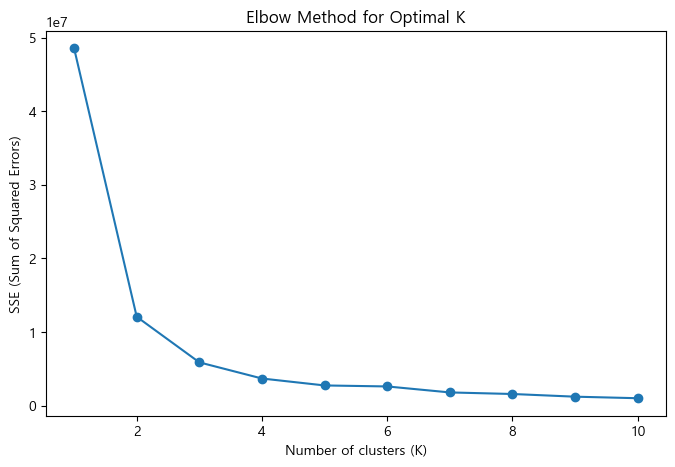

cluster
0    84790
2     3947
1     1339
Name: count, dtype: int64
Silhouette Score: 0.855


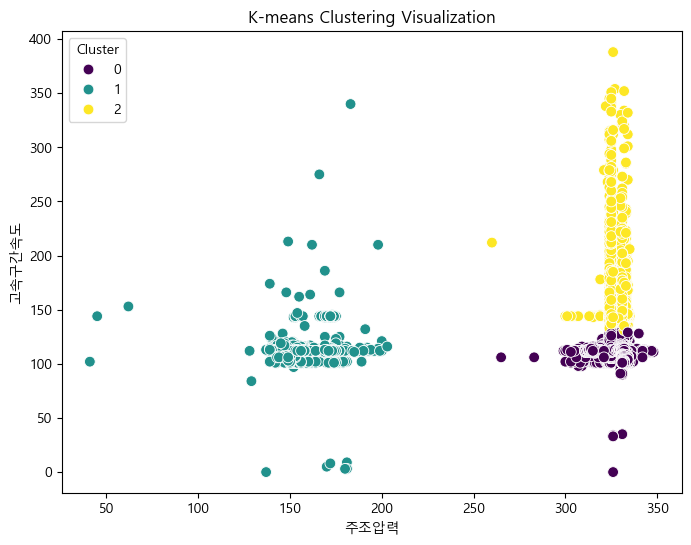

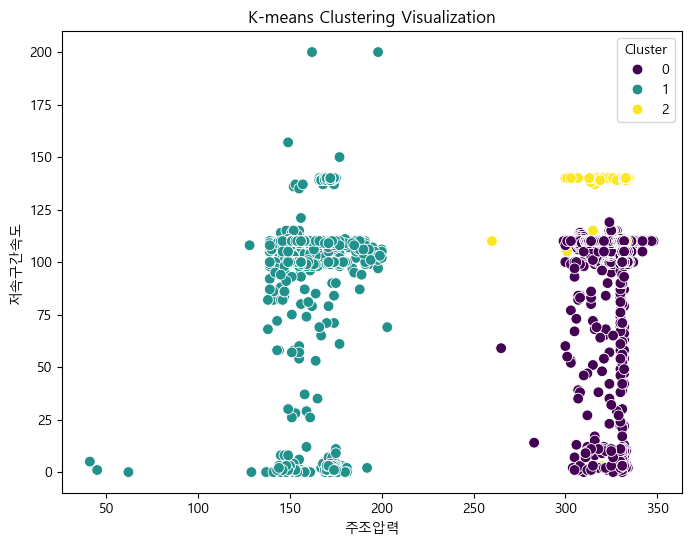

Optimization terminated successfully.
         Current function value: 0.036060
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                90076
Model:                          Logit   Df Residuals:                    90068
Method:                           MLE   Df Model:                            7
Date:                Wed, 30 Oct 2024   Pseudo R-squ.:                  0.6726
Time:                        15:00:25   Log-Likelihood:                -3248.1
converged:                       True   LL-Null:                       -9920.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.7040      5.610     -0.304      0.761     -12.699       9.292
주조압력                   0.0368      0.020      1.843      0.065      -0.002       0.076
고속구간속도                 0.0463      0.050      0.934      0.350      -0.051       0.143
저속구간속도                 0.1799      0.059      3.036      0.002       0.064       0.296
주조압력_고속구간속도_저속구간속도  5.687e-06   1.73e-06      3.296      0.001    2.31e-06    9.07e-06
주조압력_고속구간속도           -0.0003      0.000     -1.985      0.047      -0.001   -4.36e-06
주조압력_저속구간속도           -0.0011      0.000     -5.656      0.000      -0.002      -0.001
고속구간속도_저속구간속도         -0.0008      0.001     -1.560      0.119      -0.002       0.000
======================================================================================
"""

In [264]:
# 엘보우 기법(최적의 K값 찾기)
# 변수 구분하기
X = df[['주조압력', '고속구간속도']].values

# 엘보우 기법을 통해 최적의 K값 찾기
sse = []
k_range = range(1, 11)  # K값을 1부터 10까지 변경하며 탐색

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # 각 K에 대한 SSE 저장

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.show()

# k = 3일 때 군집화(군집화 + 성능 평가 + 시각화)
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 클러스터 할당 결과 확인
print(df['cluster'].value_counts())

# 군집 성능 평가하기
# 클러스터 레이블 가져오기
labels = df['cluster']

# 실루엣 점수 계산
silhouette_avg = silhouette_score(df[['주조압력', '고속구간속도']], labels)

print(f"Silhouette Score: {silhouette_avg:.3f}") 


# 주요 두 변수 선택하여 2D 산점도 시각화(주조 x 고속)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['주조압력'], y=df['고속구간속도'], hue=df["cluster"], palette='viridis', s=60)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids', marker='x')
plt.title("K-means Clustering Visualization")
plt.xlabel("주조압력")
plt.ylabel("고속구간속도")
plt.legend(title = "Cluster")
plt.show()

# 주요 두 변수 선택하여 2D 산점도 시각화(주조 x 저속)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['주조압력'], y=df['저속구간속도'], hue=df["cluster"], palette='viridis', s=60)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids', marker='x')
plt.title("K-means Clustering Visualization")
plt.xlabel("주조압력")
plt.ylabel("저속구간속도")
plt.legend(title = "Cluster")
plt.show()

# cluster = 0일 때 2일 때 min, max값, 불량률
# cluster = 0일 때
df0 = df[df["cluster"] == 0]

df0["저속구간속도"].min() # 0
df0["저속구간속도"].max() # 119

# 불량률 구하기
a = len(df0[df0["불량판정"] == 1])
b = len(df0)

(a/b) * 100 # 0.66


# cluster = 2일 때 
df2 = df[df["cluster"] == 2]

df2["저속구간속도"].min() # 3
df2["저속구간속도"].max() # 140

# 파생변수 + 로지스틱

from sklearn.linear_model import LogisticRegression

# 파생변수 생성
df['주조압력_고속구간속도'] = df['주조압력'] * df['고속구간속도']
df['주조압력_저속구간속도'] = df['주조압력'] * df['저속구간속도']
df['주조압력_고속구간속도_저속구간속도'] = df['주조압력'] * df['고속구간속도'] * df['저속구간속도']
df['고속구간속도_저속구간속도'] = df['고속구간속도'] * df['저속구간속도']

# 독립 변수와 종속 변수 설정
X = df[['주조압력', '고속구간속도', '저속구간속도', 
        '주조압력_고속구간속도_저속구간속도', '주조압력_고속구간속도', '주조압력_저속구간속도', '고속구간속도_저속구간속도']]
df['불량판정'] = df['불량판정'].astype('category')
y = df['불량판정'].cat.codes  # 불량판정을 0과 1로 변환

import statsmodels.api as sm
# statsmodels를 이용한 로지스틱 회귀 분석
X = sm.add_constant(X)  # 상수항 추가 
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 회귀 결과 요약 출력
result.summary()